In [1]:
#import imaging_behavior_functions
import imaging_behavior_functions_cleaned
import imaging_behavior_functions_plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from scipy.stats import circmean, circstd, circvar



### Load old

In [2]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/"
folder_name = "20230817-3_MBON09_GCAMP7f_odor_apple_patchy_fly2"
example_path_data = base_path+folder_name+"/data/"
example_path_results = base_path+folder_name+"/results/"
trial_num = 1

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions_cleaned.load_intermediate_mat(example_path_data, trial_num)
behav_df = imaging_behavior_functions_cleaned.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor, trial_num, ball_d=9)
behav_df = imaging_behavior_functions_cleaned.reconstruct_path(behav_df, ball_d=9)
# calculate straightness
behav_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(behav_df)
if 'odor_state' in behav_df.columns and np.mean(behav_df.odor_state) != 0:
    behav_df = imaging_behavior_functions_cleaned.compute_event_metrics_3(behav_df)
roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = imaging_behavior_functions_cleaned.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions_cleaned.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions_cleaned.make_df_neural(
    dff_all_rois,
    dff_time,
    roi_names,
    hdeltab_index,
    epg_index,
    fr1_index,
    fb4r_index,
    hdeltab_sequence,
    epg_sequence,
    fr1_sequence,
    fb4r_seq
)
neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
neural_df = imaging_behavior_functions_cleaned.add_dan_mean_columns(neural_df)
#neural_df = add_min_max_normalized_columns(neural_df)
roi_kw = 'hDeltaB'
roi_kw2 = 'MB'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions_cleaned.extract_roi_mtx(neural_df, roi_kw, roi_kw2)
    neural_df,param_df = imaging_behavior_functions_cleaned.fit_sinusoid(neural_df, roi_mtx)
    neural_df = imaging_behavior_functions_cleaned.calculate_pva_hdeltab(roi_mtx.T,neural_df)
merged_df = imaging_behavior_functions_cleaned.merge_dataframes(behav_df, neural_df)

Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.


In [18]:
shifted_heading = (merged_df['heading'] + np.pi) % (2 * np.pi)
merged_df['shifted_heading'] = shifted_heading

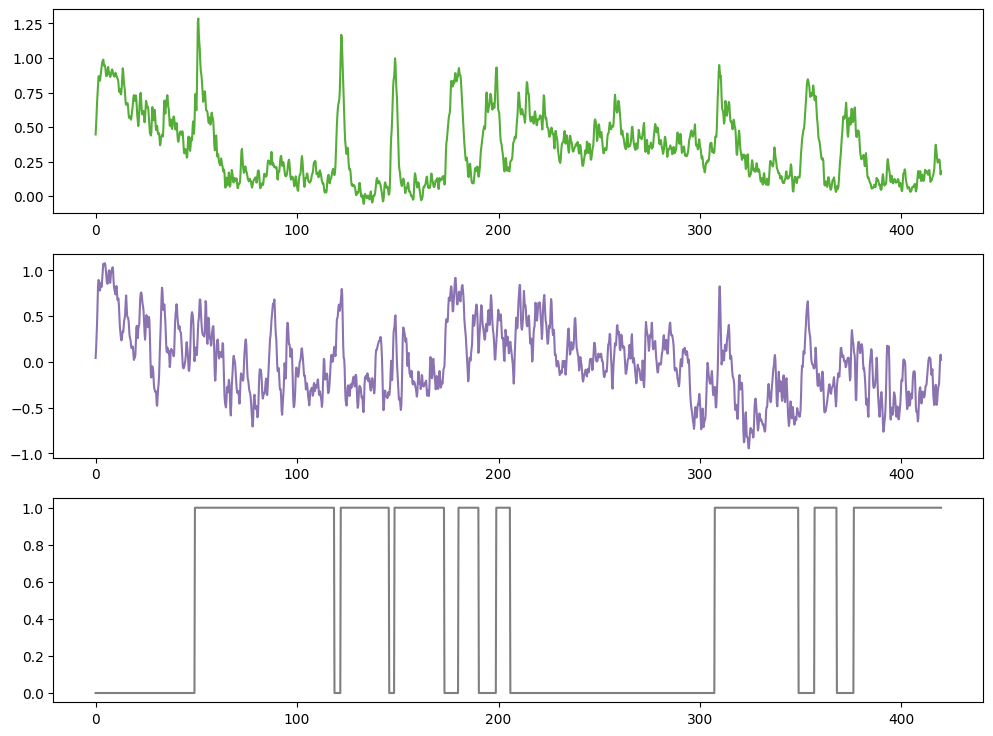

In [9]:
key = 'mean_MBON09'
fig, ax = plt.subplots(3, 1, figsize=(12, 9))
idx1 = 0
idx2 = -1
ax[0].plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2],color=(41/256,154/256,4/256),alpha=0.8)
#ax1=ax[0].twinx()
#ax1.scatter(merged_df.time[idx1:idx2], merged_df['baseline'][idx1:idx2],color='red',s=50,alpha=0.5)
ax[1].plot(merged_df.time[idx1:idx2], merged_df.baseline[idx1:idx2],color=(110/256,80/256,160/256),alpha=0.8)
# ax2=ax[1].twinx()
#ax2.scatter(merged_df.time[idx1:idx2], merged_df['novelty_score'][idx1:idx2],color='red',alpha=0.5)
ax[2].plot(merged_df.time[idx1:idx2], merged_df['odor_state'][idx1:idx2],color='black',alpha=0.5)

plt.savefig('saved_images/mbon09_hdeltab.pdf', facecolor='none', bbox_inches='tight', dpi=300)

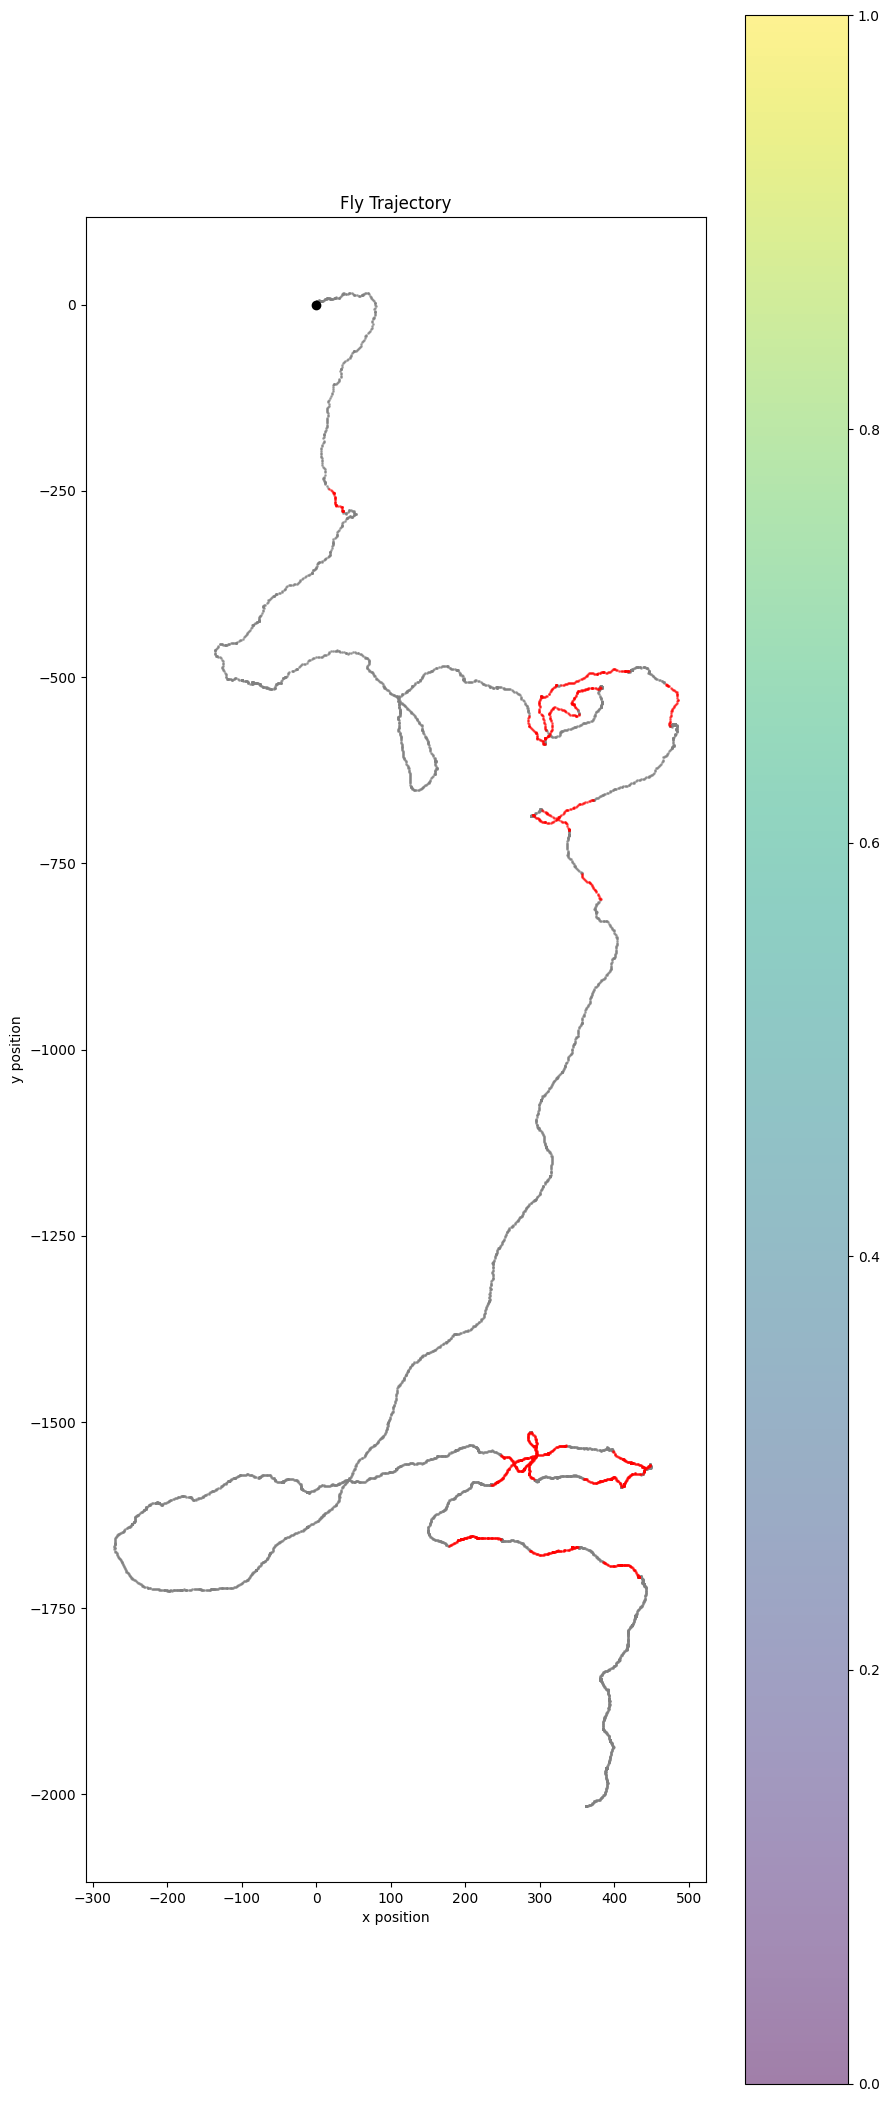

In [3]:
idx1=0
idx2=-1
imaging_behavior_functions_plotting.plot_fly_traj(merged_df.xPos[idx1:idx2], merged_df.yPos[idx1:idx2], merged_df[idx1:idx2], 'odor_state',colormap=cm.viridis)

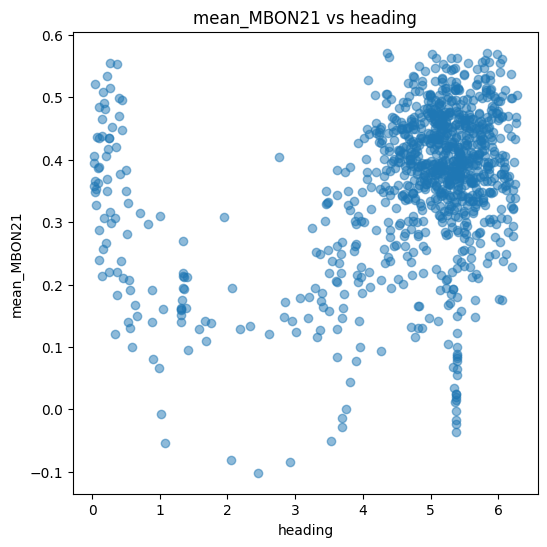

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))
imaging_behavior_functions_plotting.plot_scatter(merged_df[idx1:idx2], 'heading', key, ax=ax, return_fig=False)

d:\Wilson lab\analysis\thesis-2p-behavior-align\imaging\imaging_behavior_functions_plotting.py:410: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fwV_bin'] = pd.cut(df[fwV_col], bins=fwV_bins, labels=False, include_lowest=True)
d:\Wilson lab\analysis\thesis-2p-behavior-align\imaging\imaging_behavior_functions_plotting.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['heading_bin'] = pd.cut(df[heading_col], bins=heading_bins, labels=False, include_lowest=True)


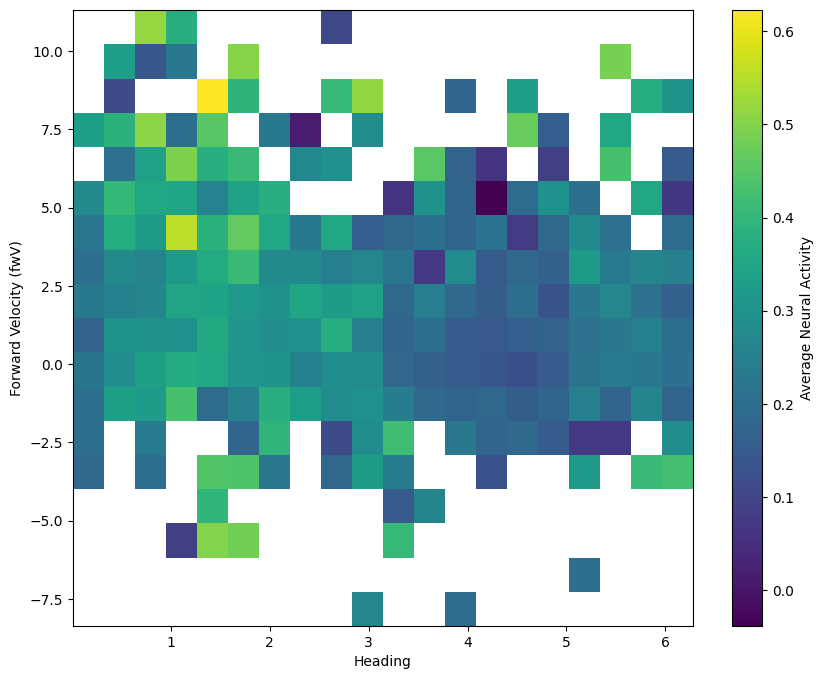

In [76]:
imaging_behavior_functions_plotting.plot_neural_activity_heatmap(merged_df.iloc[idx1:idx2], key, 'fwV', 'phase', modal_heading=None, num_bins_fwV=20, num_bins_heading=20)

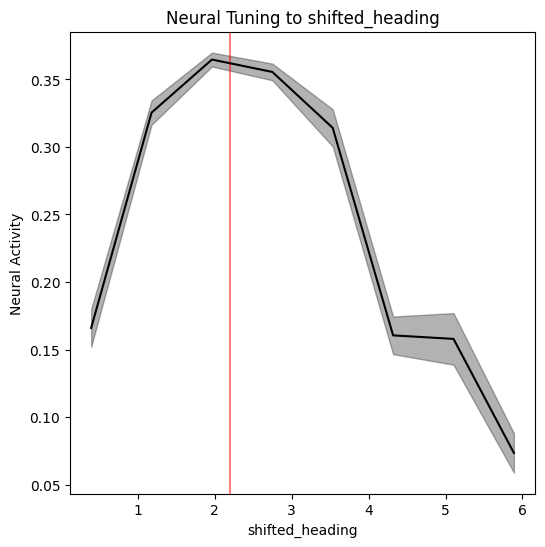

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
idx1 = 0
idx2 = -1
circular_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['shifted_heading'], method='histogram')
ax.axvline(circular_mode,color='red',alpha=0.5)
imaging_behavior_functions_plotting.tuning_curve_1d(merged_df[idx1:idx2], 'shifted_heading', key, num_bins=8, ax=ax, return_fig=False)



Original circular mode: 2.199114857512855
Shift amount: 0.9424777960769379
New circular mode: 3.036872898470133


Text(0.5, 1.0, 'Tuning curve with mode centered at π')

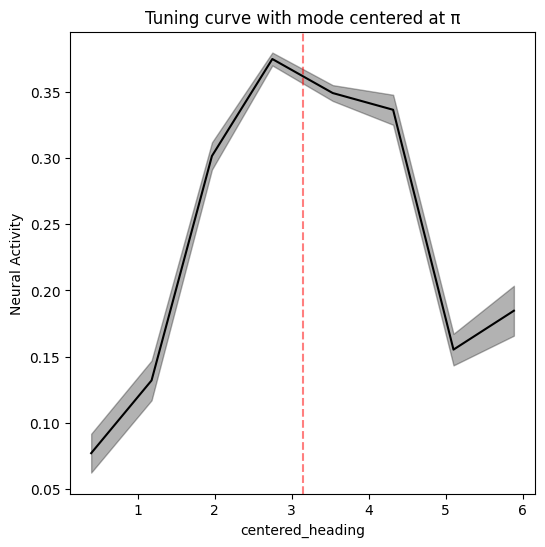

In [33]:
# Shift the heading data to make circular mode at np.pi
circular_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['shifted_heading'], method='histogram')
print(f"Original circular mode: {circular_mode}")

# Calculate the shift needed to center the mode at np.pi
shift_amount = np.pi - circular_mode
print(f"Shift amount: {shift_amount}")

# Apply the shift and ensure values stay within [0, 2π]
centered_heading = (merged_df['shifted_heading'] + shift_amount) % (2 * np.pi)
merged_df['centered_heading'] = centered_heading

# Verify the new mode is at np.pi
new_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['centered_heading'], method='histogram')
print(f"New circular mode: {new_mode}")

# Create the plot with the centered heading
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvline(np.pi, color='red', linestyle='--', alpha=0.5, label='Circular Mode')
imaging_behavior_functions_plotting.tuning_curve_1d(
    merged_df[idx1:idx2], 
    'centered_heading', 
    key, 
    num_bins=8, 
    ax=ax, 
    return_fig=False
)
ax.set_title(f'Tuning curve with mode centered at π')
#ax.legend()

<PolarAxes: >

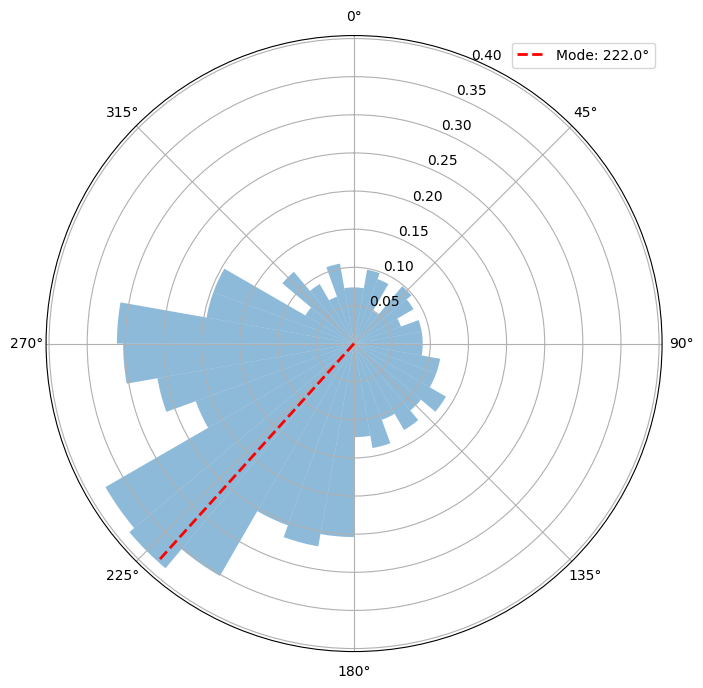

In [124]:
imaging_behavior_functions_plotting.plot_heading_histogram_circular(shifted_heading[idx1:idx2], n_bins=36, ax=None, density=True, offset=0, direction='clockwise', zero_location='N')

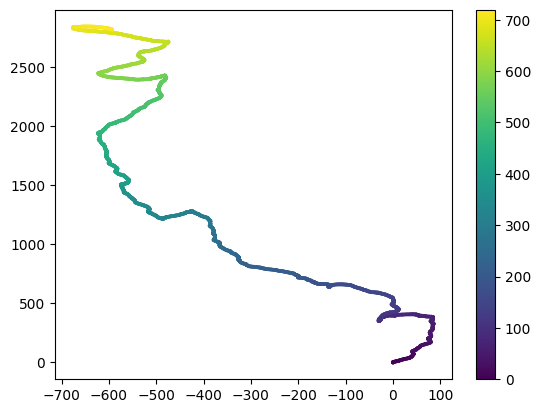

In [80]:
fig = plt.scatter(behav_df.xPos[idx1:idx2],behav_df.yPos[idx1:idx2],s=3,c = behav_df.time[idx1:idx2])
plt.colorbar(fig)

### Load new and examine bar sweep

#### Useful functions

In [20]:
def compute_prestimulus_metrics(df, state_col="odor_state", time_col="time",
                                fwv_col="fwV", heading_col="heading", rho_t_col="rho_t",
                                pre_window=5):
    """
    Computes prestimulus locomotion metrics at off-to-on transitions.
    
    For each off-to-on transition (i.e., when the state changes from 0 to 1), the following metrics are computed:
      - Prestimulus average forward velocity (fwV) over the time window preceding the transition.
      - Prestimulus circular average of heading.
      - Prestimulus circular variance of heading (assuming heading is in the range [0, π]).
      - Prestimulus average rho_t (straightness measure).
      - Average fwV during the entire on period (from transition onset to next off transition).
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing locomotion data.
    - state_col (str): Name of the binary state column (0 = off, 1 = on).
    - time_col (str): Name of the time column.
    - fwv_col (str): Column name for forward velocity.
    - heading_col (str): Column name for heading (in radians, assumed to be in [0, π]).
    - rho_t_col (str): Column name for straightness measure.
    - pre_window (float): Duration (in the same units as time_col) of the prestimulus window.
    
    Returns:
    - pd.DataFrame with the following additional columns:
        - 'prestim_avg_fwv': Prestimulus average forward velocity.
        - 'prestim_circavg_heading': Prestimulus circular average of heading.
        - 'prestim_circvar_heading': Prestimulus circular variance of heading.
        - 'prestim_avg_rho_t': Prestimulus average straightness.
        - 'on_avg_fwv': Average forward velocity during the on period.
    """


    # Identify off-to-on transitions: where the previous state is 0 and the current state is 1.
    onset_indices = df.index[(df[state_col].shift(1, fill_value=0) == 0) & (df[state_col] == 1)]
    # Identify on-to-off transitions for computing on period metrics.
    offset_indices = df.index[(df[state_col].shift(1, fill_value=1) == 1) & (df[state_col] == 0)]

    # Initialize new metric columns with NaN.
    df["prestim_avg_fwv"] = np.nan
    df["prestim_circavg_heading"] = np.nan
    df["prestim_circvar_heading"] = np.nan
    df["prestim_avg_rho_t"] = np.nan
    df["on_avg_fwv"] = np.nan

    for event_idx in onset_indices:
        event_time = df.loc[event_idx, time_col]

        # Define prestimulus window: from (event_time - pre_window) to event_time.
        window_start_time = event_time - pre_window
        prestim_window = df[(df[time_col] >= window_start_time) & (df[time_col] < event_time)]

        if not prestim_window.empty:
            # Calculate prestimulus metrics.
            df.loc[event_idx, "prestim_avg_fwv"] = prestim_window[fwv_col].mean()
            df.loc[event_idx, "prestim_avg_rho_t"] = prestim_window[rho_t_col].mean()
            # Compute circular statistics for heading.
            df.loc[event_idx, "prestim_circavg_heading"] = circmean(prestim_window[heading_col])
            df.loc[event_idx, "prestim_circvar_heading"] = circvar(prestim_window[heading_col])

        # Define the on period: from the event time to the next off event.
        next_offsets = offset_indices[offset_indices > event_idx]
        if not next_offsets.empty:
            next_off_idx = next_offsets.min()
            on_window = df[(df[time_col] >= event_time) & (df[time_col] < df.loc[next_off_idx, time_col])]
        else:
            # If no subsequent off event exists, take all data from event_time to end.
            on_window = df[df[time_col] >= event_time]

        if not on_window.empty:
            df.loc[event_idx, "on_avg_fwv"] = on_window[fwv_col].mean()

    return df


def plot_neural_activity(df, pre_window_size, post_window_size, plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"], sigma=None, plot_kw='past_interval', is_onset=True, bounds=[10, 25, 100, 200],percentile_range=[0, 100]):
    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")

    if "time" not in df.columns:
        raise ValueError("Column 'time' not found in the dataframe.")

    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_filter1d(df[column], sigma)

    heading_onsets = df.index[(df["heading_state"].shift(1, fill_value=0) == 0) & (df["heading_state"] == 1)]
    heading_offsets = df.index[(df["heading_state"].shift(1, fill_value=0) == 1) & (df["heading_state"] == 0)]

    fig, axs = plt.subplots(len(plot_columns) // 2, 2, figsize=(12, 2 * len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces = []
        trace_colors = []
        
        column = f"{column}_smoothed" if sigma else column

        for j in range(len(heading_onsets) - 1):
            onset = heading_onsets[j]
            offset = heading_offsets[j]
            
            if is_onset:
                start = max(0, onset - pre_window_size)
                end = min(len(df), onset + post_window_size)
                time_ref = onset
            else:
                start = max(0, offset - pre_window_size)
                end = min(len(df), offset + post_window_size)
                time_ref = offset
            
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[time_ref]

            if np.array(time_trace)[-1] > 0 and np.array(time_trace)[0] < 0:
                aligned_traces.append((time_trace.reset_index(drop=True), trace))
                if is_onset:
                    value = df.loc[onset, plot_kw]
                else:
                    value = df.loc[offset, plot_kw]
                if value is not None:
                    trace_colors.append(value)
        
        if trace_colors:
            lower_bound, upper_bound = np.percentile(trace_colors, percentile_range)
            norm = plt.Normalize(max(min(trace_colors), lower_bound), min(max(trace_colors), upper_bound))
            cmap = plt.cm.rainbow
        
        for idx, (time_trace, trace) in enumerate(aligned_traces):
            color = cmap(norm(trace_colors[idx])) if trace_colors else "blue"
            axs[i].plot(time_trace, trace, alpha=0.4, color=color)

        if bounds:
            grouped_traces = {str(idx): [] for idx in range(len(bounds) + 1)}
            
            for idx, value in enumerate(trace_colors):
                if value < bounds[0]:
                    grouped_traces["0"].append(aligned_traces[idx][1])
                else:
                    for b_idx in range(1, len(bounds)):
                        if bounds[b_idx - 1] <= value < bounds[b_idx]:
                            grouped_traces[str(b_idx)].append(aligned_traces[idx][1])
                            break
                    else:
                        grouped_traces[str(len(bounds))].append(aligned_traces[idx][1])
            
            for group, traces in grouped_traces.items():
                if traces:
                    mean_trace = pd.DataFrame(traces).mean()
                    mean_time = pd.Series([-pre_window_size + i for i in range(pre_window_size + post_window_size)])
                    
                    group_values = [trace_colors[idx] for idx, value in enumerate(trace_colors)
                                    if (value < bounds[0] and group == "0") or
                                    any(bounds[b_idx - 1] <= value < bounds[b_idx] and group == str(b_idx) for b_idx in range(1, len(bounds))) or
                                    (value >= bounds[-1] and group == str(len(bounds)))]
                    
                    if group_values:
                        group_avg = np.mean(group_values)
                        color = cmap(norm(group_avg))
                        axs[i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")
     
        
        axs[i].axvline(x=0, color='red', linestyle='--', label='Heading Onset')
        
        if trace_colors:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axs[i])
            cbar.set_label(f"{plot_kw.capitalize()} Value")
        
        axs[i].set_title(f"Neural Activity: {column}")
        axs[i].set_xlabel(f"Time (seconds, aligned to heading {'onset' if is_onset else 'offset'})")
        axs[i].set_ylabel("Activity")
    
    plt.tight_layout()
    plt.show()


def plot_aligned_traces_twinx(
    df, 
    binary_col, 
    query_cols,  # expects exactly two columns: e.g. ['MBON09', 'heading']
    time_col, 
    align_to="on", 
    window=(-1, 1), 
    is_circular=False,  # can be a boolean or list/tuple of booleans [for left, for right]
    do_baselincorr=True
):
    """
    Plots two query variable traces aligned to binary state transitions.
    The first variable (query_cols[0]) is plotted on the left y-axis,
    while the second variable (query_cols[1]) is plotted on a twin y-axis.
    For each variable, if it is circular (e.g. angles in radians) it is plotted as a scatter plot.
    
    Parameters:
      - df: DataFrame containing the time series.
      - binary_col: Column name used to detect transitions (e.g., landmark jumps).
      - query_cols: List of exactly two column names (e.g., ['MBON09', 'heading']).
      - time_col: Column name with time values.
      - align_to: Either "on" or "off" indicating which transitions to align.
      - window: Tuple (start, end) relative to the transition time.
      - is_circular: Boolean or list/tuple of booleans. If True for a variable, baseline correction 
                     uses circular statistics and the variable is plotted as scatter.
      - do_baselincorr: If True, subtracts the pre-event (t < 0) baseline from each trace.
    """

    # Allow is_circular to be specified per variable
    if not isinstance(is_circular, (list, tuple)):
        is_circular = [is_circular, is_circular]
    elif len(is_circular) != 2:
        raise ValueError("is_circular must be either a single boolean or a list/tuple of two booleans.")

    # Detect transitions (state changes)
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")
    
    num_events = len(transition_idxs)
    if num_events == 0:
        print("No transitions detected.")
        return
    
    # Create a grid of subplots: one per jump event
    ncols = int(np.ceil(np.sqrt(num_events)))
    nrows = int(np.ceil(num_events / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), squeeze=False)

    # Set default colors for the two variables
    color_left = 'b'
    color_right = 'r'
    
    # Iterate over each event
    for i, idx in enumerate(transition_idxs):
        ax = axs[i // ncols, i % ncols]
        t0 = df.loc[idx, time_col]
        start_time = t0 + window[0]
        end_time = t0 + window[1]
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]
        if subset.empty:
            continue
        
        # Align time to the event (t=0)
        aligned_time = subset[time_col].values - t0

        # Calculate average forward velocity (fwV) in the prestimulus window (t < 0)
        if 'fwV' in subset.columns:
            prestim_mask = aligned_time < 0
            if prestim_mask.any():
                avg_fwV = np.mean(np.abs(subset.loc[prestim_mask, 'fwV'].values))
            else:
                avg_fwV = np.nan
        else:
            avg_fwV = np.nan


        # Process first variable (left y-axis)
        trace_left = subset[query_cols[0]].values.copy()
        if do_baselincorr:
            baseline_mask = aligned_time < 0
            baseline_vals = trace_left[baseline_mask] if baseline_mask.any() else trace_left
            if is_circular[0]:
                baseline = np.angle(np.mean(np.exp(1j * baseline_vals)))
                if baseline < 0:
                    baseline += 2 * np.pi
                trace_left = (trace_left - baseline) % (2 * np.pi)
            else:
                baseline = np.mean(baseline_vals)
                trace_left = trace_left - baseline

        # Plot left variable using scatter if circular, otherwise a line
        if is_circular[0]:
            ax.scatter(aligned_time, trace_left, color=color_left, label=query_cols[0], s=5,alpha=0.5)
        else:
            ax.plot(aligned_time, trace_left, color=color_left, label=query_cols[0], alpha=0.5)
        
        ax.set_xlabel("Time (s, aligned to jump)")
        ax.set_ylabel(query_cols[0], color=color_left)
        ax.set_ylim(0, 2*np.pi) if is_circular[0] else [-0.15,0.3]
        ax.tick_params(axis='y', labelcolor=color_left)
        ax.axvline(0, color="k", linestyle="--", linewidth=1)
        ax.grid(True)

        # Process second variable (right y-axis)
        trace_right = subset[query_cols[1]].values.copy()
        if do_baselincorr:
            baseline_mask = aligned_time < 0
            baseline_vals = trace_right[baseline_mask] if baseline_mask.any() else trace_right
            if is_circular[1]:
                baseline = np.angle(np.mean(np.exp(1j * baseline_vals)))
                if baseline < 0:
                    baseline += 2 * np.pi
                trace_right = (trace_right - baseline + np.pi) % (2 * np.pi) 
            else:
                baseline = np.mean(baseline_vals)
                trace_right = trace_right - baseline

        # Create twin axis for second variable and plot accordingly
        ax2 = ax.twinx()
        if is_circular[1]:
            ax2.scatter(aligned_time, trace_right, color=color_right, label=query_cols[1], s=5,alpha=0.5)
        else:
            ax2.plot(aligned_time, trace_right, color=color_right, label=query_cols[1], alpha=0.5)
        ax2.set_ylabel(query_cols[1], color=color_right)
        ax2.set_ylim(0, 2*np.pi) if is_circular[1] else [-0.15,0.3]
        ax2.tick_params(axis='y', labelcolor=color_right)

        #ax.set_title(f"Jump event at t={t0:.2f}")

        # Combine legends from both axes
        lines_left, labels_left = ax.get_legend_handles_labels()
        lines_right, labels_right = ax2.get_legend_handles_labels()
        ax.legend(lines_left + lines_right, labels_left + labels_right, loc="upper left")
        ax.set_title(f"Jump at t={t0:.2f}\nAvg net_motion_state (pre-stim): {avg_fwV:.2f}")
    
    # Remove any unused subplots
    total_subplots = nrows * ncols
    for k in range(i+1, total_subplots):
        fig.delaxes(axs[k // ncols, k % ncols])
    
    fig.suptitle("Aligned Traces with Dual Axes for Each Jump Event", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_heatmap_aligned_traces(
    df, 
    binary_col, 
    query_cols,  # e.g., ['mean_MBON09', 'phase']
    time_col, 
    align_to="on", 
    window=(-1, 1), 
    is_circular=False,  # either a single bool (applied to all) or a list of booleans per variable
    do_baselincorr=True
):
    """
    Creates heatmaps of aligned traces for each jump event.
    
    Each row of the heatmap corresponds to one jump event, and the columns represent
    time (relative to the jump). Two heatmaps are produced (one per variable in query_cols):
      - For non-circular variables (e.g. mean_MBON09), a sequential colormap is used.
      - For circular variables (e.g. phase, with values between 0 and 2π), a circular colormap is used.
    
    Baseline correction (zeroing out the pre-jump mean) is applied if do_baselincorr is True.
    
    Parameters:
      - df: DataFrame with the time series.
      - binary_col: Column used to detect jump transitions.
      - query_cols: List of two column names to visualize (e.g. ['mean_MBON09', 'phase']).
      - time_col: Column name with time values.
      - align_to: 'on' or 'off', indicating which transition to align.
      - window: Tuple (start, end) specifying the window relative to the jump.
      - is_circular: Boolean or list of booleans (one per query variable) indicating if the variable is circular.
      - do_baselincorr: If True, subtract the pre-event (t < 0) baseline from each event.
    """
    import matplotlib.colors as mcolors

    # Allow is_circular to be specified per variable
    nvars = len(query_cols)
    if not isinstance(is_circular, (list, tuple)):
        is_circular = [is_circular] * nvars
    elif len(is_circular) != nvars:
        raise ValueError("is_circular must be either a single boolean or a list/tuple of booleans with the same length as query_cols")

    # Detect transitions based on binary column changes
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")

    # Dictionary to store traces for each query variable for every event.
    traces_dict = {col: [] for col in query_cols}
    time_axis = None  # we assume all events yield the same aligned time vector

    # Loop over detected events and extract traces within the specified window.
    for idx in transition_idxs:
        t0 = df.loc[idx, time_col]
        start_time = t0 + window[0]
        end_time = t0 + window[1]
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]
        if subset.empty:
            continue
        # Align time so that t=0 corresponds to the jump.
        aligned_time = subset[time_col].values - t0
        # Save the time axis from the first event.
        if time_axis is None:
            time_axis = aligned_time
        else:
            # If the event has a different number of points, skip it.
            if len(aligned_time) != len(time_axis):
                continue
        
        # Process each query variable.
        for i, col in enumerate(query_cols):
            trace = subset[col].values.copy()
            if do_baselincorr:
                baseline_mask = aligned_time < 0
                baseline_vals = trace[baseline_mask] if baseline_mask.any() else trace
                if is_circular[i]:
                    # Compute circular mean and subtract modulo 2π.
                    baseline = np.angle(np.mean(np.exp(1j * baseline_vals)))
                    if baseline < 0:
                        baseline += 2 * np.pi
                    trace = (trace - baseline) % (2 * np.pi)
                else:
                    baseline = np.mean(baseline_vals)
                    trace = trace - baseline
            traces_dict[col].append(trace)
    
    # Convert collected traces into 2D arrays: rows = events, columns = time points.
    heatmap_data = {}
    for col in query_cols:
        if len(traces_dict[col]) > 0:
            heatmap_data[col] = np.vstack(traces_dict[col])
        else:
            heatmap_data[col] = None

    # Create subplots: one heatmap per query variable.
    n_plots = len(query_cols)
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6), squeeze=False)
    
    for i, col in enumerate(query_cols):
        ax = axes[0, i]
        data = heatmap_data[col]
        if data is None:
            continue
        # For circular variables use a circular colormap (e.g., hsv) with limits 0 to 2π.
        if is_circular[i]:
            cmap = plt.get_cmap("twilight")
            norm = mcolors.Normalize(vmin=0, vmax=2 * np.pi)
        else:
            cmap = plt.get_cmap("viridis")
            norm = None
        
        # Plot the heatmap using imshow. Here the x-axis covers the time window,
        # and the y-axis indexes the jump events.
        im = ax.imshow(
            data,
            aspect="auto",
            origin="lower",
            extent=[time_axis[0], time_axis[-1], 1, data.shape[0]],
            cmap=cmap,
            norm=norm
        )
        ax.axvline(0, color='k', linestyle='--', linewidth=3)
        ax.set_xlabel("Time (s, aligned to jump)")
        ax.set_ylabel("Jump Event #")
        ax.set_title(f"Heatmap of {col}")
        fig.colorbar(im, ax=ax, label=col)
    
    fig.suptitle("Aligned Heatmaps for Jump Events", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()



def plot_event_percent_change(df, var, event_col='jump_detected', time_col='time',
                              event_window=(-5, 5), baseline_window=(-5, 0),
                              circular=False, n_points=100, title=None,
                              plot_individual=False):
    """
    Computes and plots the event-aligned percent change for a variable.
    
    The function:
      1. Detects events as 0→1 transitions in the event_col.
      2. For each event, extracts data in the time window specified by event_window
         (relative to the event time).
      3. Computes the baseline (using data in the baseline_window relative to the event).
      4. For linear variables, computes:
             percent_change = ((x - baseline) / baseline) * 100.
         For circular variables (assumed in radians), computes the circular mean and then:
             percent_change = (circular_difference / (2π)) * 100,
         where circular_difference is the minimal angular difference [–π, π] from the baseline.
      5. Interpolates each event’s percent change onto a common time grid.
      6. Plots the mean percent change across events with standard error shading.
         Optionally, it can also plot the individual event traces.
    
    Parameters:
      df             : pandas DataFrame containing at least [time_col], [var], and [event_col].
      var            : string, name of the variable to analyze.
      event_col      : string, column indicating events (e.g. binary indicator for jump events).
      time_col       : string, column name for time. If non-numeric, converted to seconds.
      event_window   : tuple (start, end) in same time units relative to the event (e.g., (-5, 5)).
      baseline_window: tuple (start, end) relative to the event time to compute the baseline.
      circular       : bool, if True, treats the variable as circular (e.g., angles in radians).
      n_points       : int, number of time points on the common grid for interpolation.
      title          : optional title string for the plot.
      plot_individual: bool, if True, plot individual event traces in the background.
    
    Returns:
      None (displays the plot).
    """
    # Work on a copy of the DataFrame.
    df = df.copy()
    
    # Ensure the time column is numeric (convert to seconds relative to the first time if needed).
    if not np.issubdtype(df[time_col].dtype, np.number):
        df[time_col] = pd.to_datetime(df[time_col])
        t0 = df[time_col].iloc[0]
        df['time_sec'] = (df[time_col] - t0).dt.total_seconds()
    else:
        df['time_sec'] = df[time_col]
    times = df['time_sec'].values

    # Detect events using the 0 -> 1 transitions in event_col.
    df['event_diff'] = df[event_col].diff().fillna(0)
    event_idx = df.index[df['event_diff'] == 1].tolist()
    if len(event_idx) == 0:
        raise ValueError("No events detected (0 -> 1 transitions in the event column).")
    
    # Create a common time grid relative to each event.
    common_time = np.linspace(event_window[0], event_window[1], n_points)
    
    # List to store each event's interpolated percent change trace.
    event_traces = []
    
    for idx in event_idx:
        event_time = df.loc[idx, 'time_sec']
        # Define the absolute time window for this event.
        window_start = event_time + event_window[0]
        window_end = event_time + event_window[1]
        segment = df[(df['time_sec'] >= window_start) & (df['time_sec'] <= window_end)]
        if segment.empty:
            continue  # Skip if no data in window.
        
        # Compute relative time for the segment (relative to the event time).
        rel_time = segment['time_sec'] - event_time
        x = segment[var].values
        
        # Identify points that fall into the baseline window.
        baseline_mask = (rel_time >= baseline_window[0]) & (rel_time < baseline_window[1])
        if not np.any(baseline_mask):
            continue  # Skip this event if no baseline data available.
        baseline_vals = x[baseline_mask]
        
        # Compute percent change.
        if circular:
            # For circular data, compute circular baseline (mean angle).
            baseline_mean = np.angle(np.mean(np.exp(1j * baseline_vals)))
            # Compute minimal circular differences (returns value in [-pi, pi]).
            pc = np.angle(np.exp(1j * (x - baseline_mean))) / (2 * np.pi) * 100.0
        else:
            baseline_mean = np.mean(baseline_vals)
            # Avoid division by zero.
            if baseline_mean == 0:
                pc = np.full_like(x, np.nan)
            else:
                pc = ((x - baseline_mean) / baseline_mean) * 100.0
        
        # Interpolate percent change onto the common time grid.
        interp_pc = np.interp(common_time, rel_time, pc, left=np.nan, right=np.nan)
        event_traces.append(interp_pc)
    
    if len(event_traces) == 0:
        raise ValueError("No valid events with baseline data were found.")
    
    # Stack traces and compute mean and standard error (SEM).
    traces_stack = np.vstack(event_traces)
    mean_trace = np.nanmean(traces_stack, axis=0)
    sem_trace = np.nanstd(traces_stack, axis=0) / np.sqrt(traces_stack.shape[0])
    
    # Create the plot.
    plt.figure(figsize=(10, 6))
    if plot_individual:
        # Plot individual event traces with a light color.
        for trace in traces_stack:
            plt.plot(common_time, trace, color='gray', alpha=0.3)
    
    # Plot mean percent change with SEM shading.
    plt.plot(common_time, mean_trace, color='blue', linewidth=2, label='Mean Percent Change')
    plt.fill_between(common_time, mean_trace - sem_trace, mean_trace + sem_trace,
                     color='blue', alpha=0.3, label='SEM')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    
    plt.xlabel("Time relative to event (s)", fontsize=12)
    plt.ylabel("Percent Change (%)", fontsize=12)
    plt.title(title if title is not None else f"Event-Aligned Percent Change of '{var}'", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_event_percent_change_smoothed(df, var, event_col='jump_detected', time_col='time',
                              event_window=(-5, 5), baseline_window=(-5, 0),
                              circular=False, n_points=100, title=None,
                              plot_individual=False, smooth_window=None):
    """
    Computes and plots the event-aligned percent change for a variable.
    
    For each event (identified as a 0→1 transition in event_col), the function:
      1. Extracts data in the window defined by event_window (relative to event time).
      2. Computes a baseline from data in baseline_window (relative to event time).
      3. Calculates percent change relative to baseline:
             - For linear variables: percent_change = ((x - baseline) / baseline) * 100.
             - For circular variables: compute the circular mean of the baseline and then
               percent_change = (minimal angular difference/(2π))*100.
      4. Interpolates each event’s percent change onto a common time grid.
      5. Optionally smooths each event trace using a moving-average filter (if smooth_window is set).
      6. Plots the mean percent change (with SEM shading) and/or individual event traces.
    
    Parameters:
      df             : pandas DataFrame containing at least [time_col], [var], and [event_col].
      var            : string, name of the variable to analyze.
      event_col      : string, column used to mark events (e.g. binary indicator for jump events).
      time_col       : string, column with time values. If non-numeric, these are converted to seconds.
      event_window   : tuple (start, end) in the same units as time_col, relative to the event time.
      baseline_window: tuple (start, end) (relative to the event) over which to compute the baseline.
      circular       : bool, if True the variable is treated as circular (radians), and circular stats are used.
      n_points       : int, number of points in the common time grid for interpolation.
      title          : optional title for the plot.
      plot_individual: bool, if True, individual event traces are plotted in the background.
      smooth_window  : int or None; if an integer > 1, each event’s percent change trace is smoothed
                       with a moving average of that window length (in points on the common grid).
    
    Returns:
      None (the function displays the plot).
    """
    df = df.copy()
    
    # Convert the time column to seconds (relative to the first time point) if necessary.
    if not np.issubdtype(df[time_col].dtype, np.number):
        df[time_col] = pd.to_datetime(df[time_col])
        t0 = df[time_col].iloc[0]
        df['time_sec'] = (df[time_col] - t0).dt.total_seconds()
    else:
        df['time_sec'] = df[time_col]
    times = df['time_sec'].values

    # Detect events via a 0 -> 1 transition in event_col.
    df['event_diff'] = df[event_col].diff().fillna(0)
    event_idx = df.index[df['event_diff'] == 1].tolist()
    if len(event_idx) == 0:
        raise ValueError("No events detected (no 0 -> 1 transitions in the event column).")
    
    # Create a common time grid relative to each event.
    common_time = np.linspace(event_window[0], event_window[1], n_points)
    
    event_traces = []  # Stores each event's (optionally smoothed) percent change trace.
    
    for idx in event_idx:
        event_time = df.loc[idx, 'time_sec']
        # Define absolute time window for this event.
        window_start = event_time + event_window[0]
        window_end   = event_time + event_window[1]
        segment = df[(df['time_sec'] >= window_start) & (df['time_sec'] <= window_end)]
        if segment.empty:
            continue  # Skip if no data available.
        
        # Compute relative time (relative to the event).
        rel_time = segment['time_sec'] - event_time
        x = segment[var].values
        
        # Identify data within the baseline window.
        baseline_mask = (rel_time >= baseline_window[0]) & (rel_time < baseline_window[1])
        if not np.any(baseline_mask):
            continue  # Skip this event if no baseline data.
        baseline_vals = x[baseline_mask]
        
        # Compute percent change for each time point.
        if circular:
            # Compute the circular mean of the baseline.
            baseline_mean = np.angle(np.mean(np.exp(1j * baseline_vals)))
            # Compute minimal angular difference (in [-pi, pi]), then normalize.
            pc = np.angle(np.exp(1j * (x - baseline_mean))) / (2 * np.pi) * 100.0
        else:
            baseline_mean = np.mean(baseline_vals)
            if baseline_mean == 0:
                pc = np.full_like(x, np.nan)
            else:
                pc = ((x - baseline_mean) / baseline_mean) * 100.0
        
        # Interpolate the computed percent change onto the common time grid.
        interp_pc = np.interp(common_time, rel_time, pc, left=np.nan, right=np.nan)
        
        # Optionally smooth the trace using a moving-average filter.
        if smooth_window is not None and smooth_window > 1:
            kernel = np.ones(smooth_window) / smooth_window
            # Use convolution with 'same' mode to retain array size.
            interp_pc = np.convolve(interp_pc, kernel, mode='same')
        
        event_traces.append(interp_pc)
    
    if len(event_traces) == 0:
        raise ValueError("No valid events with baseline data were found.")
    
    # Compute the mean and SEM across events.
    traces_stack = np.vstack(event_traces)
    mean_trace = np.nanmean(traces_stack, axis=0)
    sem_trace  = np.nanstd(traces_stack, axis=0) / np.sqrt(traces_stack.shape[0])
    
    # Plot the mean trace and optionally the SEM and/or individual traces.
    plt.figure(figsize=(10, 6))
    
    if plot_individual:
        for trace in traces_stack:
            plt.plot(common_time, trace, color='gray', alpha=0.3, linewidth=1)
    
    plt.plot(common_time, mean_trace, color='blue', linewidth=2, label='Mean Percent Change')
    plt.fill_between(common_time, mean_trace - sem_trace, mean_trace + sem_trace,
                     color='blue', alpha=0.3, label='SEM')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    
    plt.xlabel("Time relative to event (s)", fontsize=12)
    plt.ylabel("Percent Change (%)", fontsize=12)
    plt.title(title if title is not None else f"Event-Aligned Percent Change of '{var}'", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_event_percent_change_smoothed_subplot(df, var, event_col='jump_detected', time_col='time',
                                       event_window=(-5, 5), baseline_window=(-5, 0),
                                       circular=False, n_points=100, title=None,
                                       smooth_window=None):
    """
    Computes and plots the event-aligned percent change for a variable.
    
    For each event (identified as a 0→1 transition in event_col), the function:
      1. Extracts data in the time window defined by event_window (relative to the event time).
      2. Computes a baseline from the data in baseline_window (relative to the event time).
      3. Calculates percent change relative to the baseline:
             - For linear variables: percent_change = ((x - baseline) / baseline) * 100.
             - For circular variables: computes the circular mean of the baseline and then
               uses the minimal angular difference (normalized by 2π) * 100.
      4. Interpolates the computed percent change onto a common time grid.
      5. Optionally smooths the trace using a moving-average filter (if smooth_window is provided).
      6. Plots each event’s percent change trace on a separate subplot.
    
    Parameters:
      df             : pandas DataFrame containing at least [time_col], [var], and [event_col].
      var            : string, name of the variable to analyze.
      event_col      : string, column used to mark events (binary indicator for the event).
      time_col       : string, column with time values. If non-numeric, these are converted to seconds.
      event_window   : tuple (start, end) in the same units as time_col, relative to the event time.
      baseline_window: tuple (start, end) (relative to the event) over which to compute the baseline.
      circular       : bool, if True, the variable is treated as circular (in radians) and circular stats are used.
      n_points       : int, number of points in the common time grid for interpolation.
      title          : optional title for the overall plot.
      smooth_window  : int or None; if > 1, each event’s trace is smoothed with a moving average window of that length.
    
    Returns:
      None (displays the plot).
    """
    df = df.copy()
    
    # Convert the time column to seconds (relative to the first time point) if necessary.
    if not np.issubdtype(df[time_col].dtype, np.number):
        df[time_col] = pd.to_datetime(df[time_col])
        t0 = df[time_col].iloc[0]
        df['time_sec'] = (df[time_col] - t0).dt.total_seconds()
    else:
        df['time_sec'] = df[time_col]
    
    # Detect events via a 0 -> 1 transition in event_col.
    df['event_diff'] = df[event_col].diff().fillna(0)
    event_idx = df.index[df['event_diff'] == 1].tolist()
    if len(event_idx) == 0:
        raise ValueError("No events detected (no 0 → 1 transitions in the event column).")
    
    # Create a common time grid relative to each event.
    common_time = np.linspace(event_window[0], event_window[1], n_points)
    
    event_traces = []  # List to store each event's (optionally smoothed) percent change trace.
    
    for idx in event_idx:
        event_time = df.loc[idx, 'time_sec']
        # Define absolute time window for this event.
        window_start = event_time + event_window[0]
        window_end   = event_time + event_window[1]
        segment = df[(df['time_sec'] >= window_start) & (df['time_sec'] <= window_end)]
        if segment.empty:
            continue  # Skip if no data available for the event
        
        # Compute relative time for the segment.
        rel_time = segment['time_sec'] - event_time
        x = segment[var].values
        
        # Identify data within the baseline window.
        baseline_mask = (rel_time >= baseline_window[0]) & (rel_time < baseline_window[1])
        if not np.any(baseline_mask):
            continue  # Skip event if no baseline data
        baseline_vals = x[baseline_mask]
        
        # Compute percent change for each time point.
        if circular:
            # For circular variables, compute circular mean of baseline.
            baseline_mean = np.angle(np.mean(np.exp(1j * baseline_vals)))
            # Compute minimal angular difference (in [-π, π]) and normalize.
            pc = np.angle(np.exp(1j * (x - baseline_mean))) / (2 * np.pi) * 100.0
        else:
            baseline_mean = np.mean(baseline_vals)
            if baseline_mean == 0:
                pc = np.full_like(x, np.nan)
            else:
                pc = ((x - baseline_mean) / baseline_mean) * 100.0
        
        # Interpolate computed percent change onto the common time grid.
        interp_pc = np.interp(common_time, rel_time, pc, left=np.nan, right=np.nan)
        
        # Optionally smooth the trace using a moving-average filter.
        if smooth_window is not None and smooth_window > 1:
            kernel = np.ones(smooth_window) / smooth_window
            interp_pc = np.convolve(interp_pc, kernel, mode='same')
        
        event_traces.append(interp_pc)
    
    if len(event_traces) == 0:
        raise ValueError("No valid events with baseline data were found.")
    
    # Create subplots: one subplot per event trace.
    n_events = len(event_traces)
    fig, axes = plt.subplots(3, 3, figsize=(15,15), sharex=True)
    axes = axes.flatten()
    
    # If there is only one event, ensure axes is always iterable.
    if n_events == 1:
        axes = [axes]
    
    # Plot each event trace in its own subplot.
    for i, trace in enumerate(event_traces):
        ax = axes[i]
        if circular:
            ax.plot(common_time, trace, color='blue', linewidth=2)
        else:
            ax.plot(common_time, trace, color='blue', linewidth=2)
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        ax.axhline(0, color='black', linestyle='--', linewidth=1)
        ax.set_ylabel("Percent Change (%)", fontsize=12)
        ax.set_title(f"Event {i+1}", fontsize=14)
        ax.grid(True)
    
    axes[-1].set_xlabel("Time relative to event (s)", fontsize=12)
    fig.suptitle(title if title is not None else f"Event-Aligned Percent Change of '{var}'", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def plot_event_percent_absolute(df, var, event_col='jump_detected', time_col='time',
                              event_window=(-5, 5), baseline_window=(-5, 0),
                              circular=False, n_points=100, title=None,
                              plot_individual=False, smooth_window=None):
    """
    Computes and plots the event-aligned percent change for a variable.
    
    For each event detected as a 0→1 transition in event_col, the function:
      1. Extracts data in a time window (event_window) relative to the event time.
      2. Computes a baseline from data in baseline_window (relative to the event).
      3. Calculates percent change relative to the baseline:
            - For linear variables: percent_change = ((x - baseline) / baseline)*100.
            - For circular variables: computes the circular mean (baseline_mean) and then
              calculates the absolute minimal angular difference between x and baseline_mean,
              normalized by π so that a difference of π radians results in 100%.
      4. Interpolates each event's percent change onto a common time grid.
      5. Optionally applies smoothing with a moving-average filter (if smooth_window is set).
      6. Averages all event traces, computes the standard error (SEM),
         and plots the average percent change (with SEM shading). Optionally, individual traces can be overlaid.
         
    Parameters:
      df             : pandas DataFrame containing at least [time_col], [var], and [event_col].
      var            : string, the variable for which percent change is computed.
      event_col      : string, column indicating events (e.g. a binary indicator for jump events).
      time_col       : string, column for time. If non-numeric, times are converted to seconds relative to the first timestamp.
      event_window   : tuple (start, end) relative to the event time (e.g., (-5, 5) seconds).
      baseline_window: tuple (start, end) relative to event time used to compute the baseline (e.g., (-5, 0)).
      circular       : bool, if True the variable is treated as circular (in radians) using absolute differences.
      n_points       : int, number of points in the common interpolation grid.
      title          : optional plot title.
      plot_individual: bool, if True, individual event traces are also plotted (in light color).
      smooth_window  : int or None; if an integer > 1, each event trace is smoothed using a moving average of that many points.
    
    Returns:
      None (displays the plot).
    """
    df = df.copy()
    
    # Ensure time is numeric (convert to seconds relative to the first timestamp if needed)
    if not np.issubdtype(df[time_col].dtype, np.number):
        df[time_col] = pd.to_datetime(df[time_col])
        t0 = df[time_col].iloc[0]
        df['time_sec'] = (df[time_col] - t0).dt.total_seconds()
    else:
        df['time_sec'] = df[time_col]
    times = df['time_sec'].values

    # Detect events via a 0->1 transition in event_col.
    df['event_diff'] = df[event_col].diff().fillna(0)
    event_idx = df.index[df['event_diff'] == 1].tolist()
    if len(event_idx) == 0:
        raise ValueError("No events detected (no 0 -> 1 transitions in the event column).")
    
    # Create a common time grid relative to event (from event_window[0] to event_window[1])
    common_time = np.linspace(event_window[0], event_window[1], n_points)
    
    event_traces = []  # This list will store each event's (smoothed if desired) percent change trace.
    
    for idx in event_idx:
        event_time = df.loc[idx, 'time_sec']
        # Define the absolute window for data extraction.
        window_start = event_time + event_window[0]
        window_end   = event_time + event_window[1]
        segment = df[(df['time_sec'] >= window_start) & (df['time_sec'] <= window_end)]
        if segment.empty:
            continue  # Skip if no data in the specified event window.
        
        # Compute time relative to the event.
        rel_time = segment['time_sec'] - event_time
        x = segment[var].values
        
        # Select baseline data within baseline_window.
        baseline_mask = (rel_time >= baseline_window[0]) & (rel_time < baseline_window[1])
        if not np.any(baseline_mask):
            continue  # Skip this event if no baseline data is found.
        baseline_vals = x[baseline_mask]
        
        # Compute percent change:
        if circular:
            # Compute the circular mean of the baseline.
            baseline_mean = np.angle(np.mean(np.exp(1j * baseline_vals)))
            # Compute minimal angular difference (in [-pi, pi]) for each value then take absolute value.
            # Normalize by π so that |angle difference|=π corresponds to 100% change.
            pc = np.abs(np.angle(np.exp(1j * (x - baseline_mean)))) / np.pi * 100.0
        else:
            baseline_mean = np.mean(baseline_vals)
            if baseline_mean == 0:
                pc = np.full_like(x, np.nan)
            else:
                pc = ((x - baseline_mean) / baseline_mean) * 100.0
        
        # Interpolate the percent change trace to the common time grid.
        interp_pc = np.interp(common_time, rel_time, pc, left=np.nan, right=np.nan)
        
        # Optional smoothing of the trace using a moving average.
        if smooth_window is not None and smooth_window > 1:
            kernel = np.ones(smooth_window) / smooth_window
            interp_pc = np.convolve(interp_pc, kernel, mode='same')
        
        event_traces.append(interp_pc)
    
    if len(event_traces) == 0:
        raise ValueError("No valid events with baseline data were found.")
    
    # Stack the traces into an array for averaging.
    traces_stack = np.vstack(event_traces)
    mean_trace = np.nanmean(traces_stack, axis=0)
    sem_trace  = np.nanstd(traces_stack, axis=0) / np.sqrt(traces_stack.shape[0])
    
    # Create the plot: plot mean with SEM shading (and optionally the individual traces).
    plt.figure(figsize=(10, 6))
    
    if plot_individual:
        for trace in traces_stack:
            plt.plot(common_time, trace, color='gray', alpha=0.3, linewidth=1)
    
    plt.plot(common_time, mean_trace, color='blue', linewidth=2, label='Mean Percent Change')
    plt.fill_between(common_time, mean_trace - sem_trace, mean_trace + sem_trace,
                     color='blue', alpha=0.3, label='SEM')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    
    plt.xlabel("Time relative to event (s)", fontsize=12)
    plt.ylabel("Percent Change (%)", fontsize=12)
    plt.title(title if title is not None else f"Event-Aligned Percent Change of '{var}'", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [21]:
import numpy as np
import pandas as pd

def detect_bar_sweep(df, t_sweep, t_interval, duration_tol=0.5, heading_tol=np.pi/2,
                     head_start_tol=0.3, interval_tol=0.2):
    """
    Detects sweep periods in a time series DataFrame using phase criteria and a fixed, regular interval.
    
    After the first sweep is successfully detected, its end time is used as the ground truth for
    subsequent sweeps. Each sweep is expected to occur roughly t_interval seconds after the previous
    one. Every sweep should start with a heading near 0 and execute an unwrapped heading change of 
    approximately 2π over a duration of t_sweep seconds (within ±duration_tol).
    
    Parameters:
      df             : pandas DataFrame with a 'heading' column (radians in [0, 2π)) and a 'time' column.
                       The 'time' column may be datetime-like or numeric.
      t_sweep        : Expected duration (in seconds) of each sweep.
      t_interval     : Expected duration (in seconds) of the non-sweep period between sweeps.
                       (For example, around 90 seconds.)
      duration_tol   : Tolerance factor for matching the sweep duration (e.g., 0.5 means ±50%).
      heading_tol    : Tolerance (in radians) for the overall (unwrapped) heading change to be considered near 2π.
      head_start_tol : Tolerance (in radians) for a sweep’s starting heading to be considered near 0.
      interval_tol   : Fractional tolerance on t_interval when searching for the next sweep start.
    
    Returns:
      df             : A copy of the original DataFrame with an added 'bar_sweep' column 
                       (1 indicates data points within a detected sweep).
    """
    df = df.copy()
    
    # Convert 'time' to seconds relative to the start if not already numeric.
    if not np.issubdtype(df['time'].dtype, np.number):
        df['time'] = pd.to_datetime(df['time'])
        t0 = df['time'].iloc[0]
        df['time_sec'] = (df['time'] - t0).dt.total_seconds()
    else:
        df['time_sec'] = df['time']
    
    times = df['time_sec'].values
    n = len(times)
    
    # Unwrap the heading to compute cumulative changes across the 0->2π boundary.
    unwrapped = np.unwrap(df['heading'].values)
    
    # Initialize the bar_sweep indicator.
    df['bar_sweep'] = 0
    sweep_mask = np.zeros(n, dtype=bool)
    
    # --- Detect the FIRST sweep ---
    first_sweep_found = False
    first_start_idx, first_end_idx = None, None
    
    for i in range(n):
        # Only consider candidate start indices where the raw heading is near 0.
        if np.abs(df['heading'].iloc[i]) > head_start_tol:
            continue
        
        # Define the candidate sweep window based on t_sweep and duration tolerance.
        lo_time = times[i] + t_sweep * (1 - duration_tol)
        hi_time = times[i] + t_sweep * (1 + duration_tol)
        j = np.searchsorted(times, lo_time, side='left')
        if j >= n:
            break
        
        if times[j] <= hi_time:
            # Compute the total heading change in this window.
            delta_heading = unwrapped[j] - unwrapped[i]
            if np.abs(delta_heading - 2*np.pi) < heading_tol:
                sweep_mask[i:j+1] = True
                first_start_idx, first_end_idx = i, j
                first_sweep_found = True
                break

    if not first_sweep_found:
        print("No valid first sweep found based on the provided timing and phase criteria.")
        df.drop('time_sec', axis=1, inplace=True)
        return df
    
    # --- Use the end time of the first sweep as ground truth for subsequent sweeps ---
    previous_sweep_end = times[first_end_idx]
    next_expected_start = previous_sweep_end + t_interval
    
    while next_expected_start < times[-1]:
        # Define an acceptable window for the next sweep's start.
        lower_bound = next_expected_start - interval_tol * t_interval
        upper_bound = next_expected_start + interval_tol * t_interval
        candidate_start = np.searchsorted(times, lower_bound, side='left')
        if candidate_start >= n:
            break
        
        # If the candidate's time exceeds the upper bound, issue a warning.
        if times[candidate_start] > upper_bound:
            print(f"Warning: Expected sweep at ~{next_expected_start:.2f} sec not found; got {times[candidate_start]:.2f} instead.")
            break
        
        # Verify that the candidate's heading is near 0.
        if np.abs(df['heading'].iloc[candidate_start]) > head_start_tol:
            print(f"Candidate at time {times[candidate_start]:.2f} sec rejected: start heading not near 0.")
            next_expected_start += 0.1 * t_sweep
            continue
        
        # Define the candidate sweep window.
        lo_time = times[candidate_start] + t_sweep * (1 - duration_tol)
        hi_time = times[candidate_start] + t_sweep * (1 + duration_tol)
        j = np.searchsorted(times, lo_time, side='left')
        if j >= n:
            break
        
        if times[j] <= hi_time:
            delta_heading = unwrapped[j] - unwrapped[candidate_start]
            if np.abs(delta_heading - 2*np.pi) < heading_tol:
                sweep_mask[candidate_start:j+1] = True
                previous_sweep_end = times[j]
                next_expected_start = previous_sweep_end + t_interval
            else:
                print("Candidate sweep rejected due to insufficient heading change.")
                next_expected_start += 0.1 * t_sweep
        else:
            print("Candidate sweep rejected due to duration mismatch.")
            next_expected_start += 0.1 * t_sweep

    df['bar_sweep'] = sweep_mask.astype(int)
    df.drop('time_sec', axis=1, inplace=True)
    
    return df


In [30]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/standby/"
folder_name = "20250507-10_MBON09hDeltaB_barsweep"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 2
bar_jump = False
bar_sweep = False
is_mat73, roi_df, dff_raw = imaging_behavior_functions_cleaned.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = imaging_behavior_functions_cleaned.get_roi_seq_2(roi_df,trial_num)
dff_all_rois, dff_time = imaging_behavior_functions_cleaned.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions_cleaned.make_df_neural(
    dff_all_rois,
    dff_time,
    roi_names,
    hdeltab_index,
    epg_index,
    fr1_index,
    fb4r_index,
    hdeltab_sequence,
    epg_sequence,
    fr1_sequence,
    fb4r_seq
)
neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
roi_kw = 'hDeltaB'
roi_kw2 = 'CRE'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions_cleaned.extract_roi_mtx(neural_df, roi_kw, roi_kw2)
    neural_df = imaging_behavior_functions_cleaned.calculate_pva_hdeltab(roi_mtx.T, neural_df)
    
behav_df, neural_df_new = imaging_behavior_functions_cleaned.load_matfile_to_df(example_path_data, folder_name, trial_num,is_odor_trial=True)
behav_df = imaging_behavior_functions_cleaned.rename_dataframe(behav_df)
if bar_jump:
    behav_df = imaging_behavior_functions_cleaned.compute_absolute_circular_diff(behav_df)
    #behav_df = imaging_behavior_functions_cleaned.detect_local_peaks(behav_df, init_t=0, prominence=0.1, min_time_gap=60)
behav_df = imaging_behavior_functions_cleaned.make_df_behavior_new(behav_df)
behav_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(behav_df)
merged_df = imaging_behavior_functions_cleaned.merge_dataframes(neural_df, behav_df)
if bar_sweep:
    #merged_df=imaging_behavior_functions_cleaned.detect_bar_sweep(merged_df, theta=0, t2=60, noise_threshold=0.05, duration_tol=0.5)
    merged_df=detect_bar_sweep(merged_df, t_sweep=20, t_interval=100, duration_tol=0.01, heading_tol=np.pi/4, 
                     head_start_tol=1, interval_tol=0.015)
# bar jump use nearest method, bar sweep use interp method

Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
Loaded using mat73.


#### check sweeps

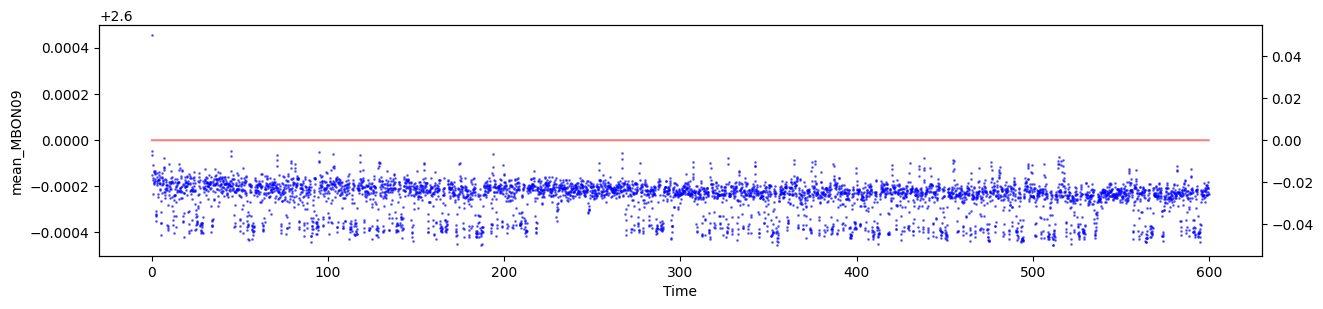

In [28]:
key = 'mean_MBON09'
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.scatter(merged_df.time[idx1:idx2], merged_df['heading'][idx1:idx2], color='blue',s=1,alpha=0.5)
ax2 = ax.twinx()
ax2.plot(merged_df.time[idx1:idx2], merged_df.bar_sweep[idx1:idx2], color='red',alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

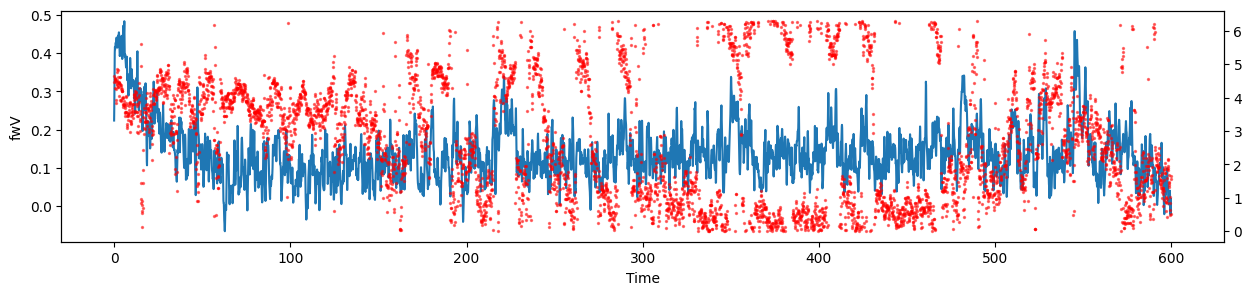

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2])
ax2 = ax.twinx()
ax2.scatter(merged_df.time[idx1:idx2], merged_df.phase[idx1:idx2], color='red',s = 2, alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel('fwV')
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

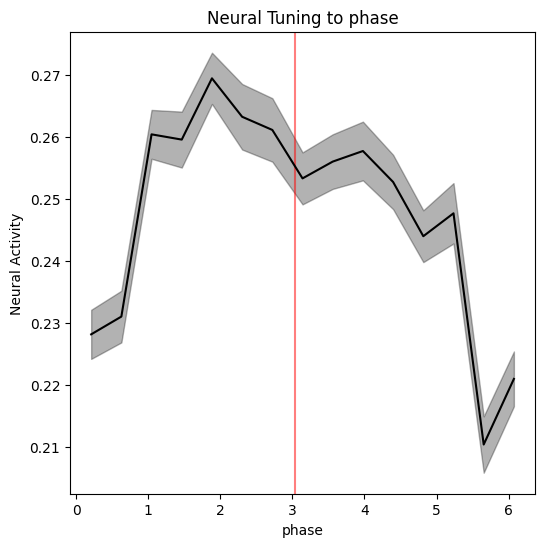

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#imaging_behavior_functions_plotting.plot_scatter(merged_df, 'phase', 'mean_MBON21', ax=ax, return_fig=False)
circular_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['phase'], method='histogram')
ax.axvline(circular_mode,color='red',alpha=0.5)
imaging_behavior_functions_plotting.tuning_curve_1d(merged_df.iloc[idx1:idx2], 'phase', key, num_bins=15, ax=ax, return_fig=False)

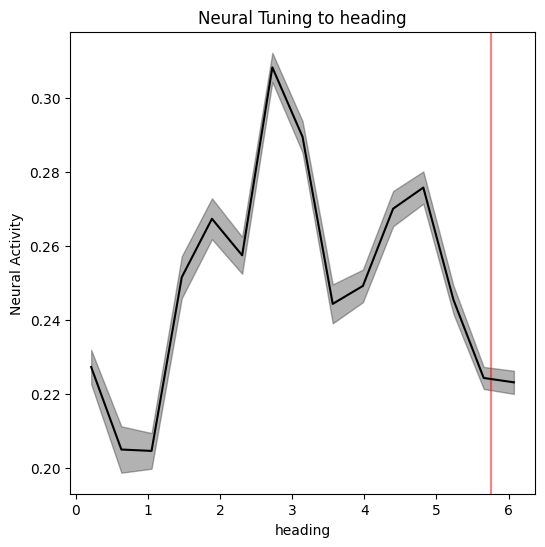

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#imaging_behavior_functions_plotting.plot_scatter(merged_df, 'phase', 'mean_MBON21', ax=ax, return_fig=False)
circular_mode = imaging_behavior_functions_plotting.circular_mode(merged_df['heading'], method='histogram')
ax.axvline(circular_mode,color='red',alpha=0.5)
imaging_behavior_functions_plotting.tuning_curve_1d(merged_df.iloc[idx1:idx2], 'heading', key, num_bins=15, ax=ax, return_fig=False)

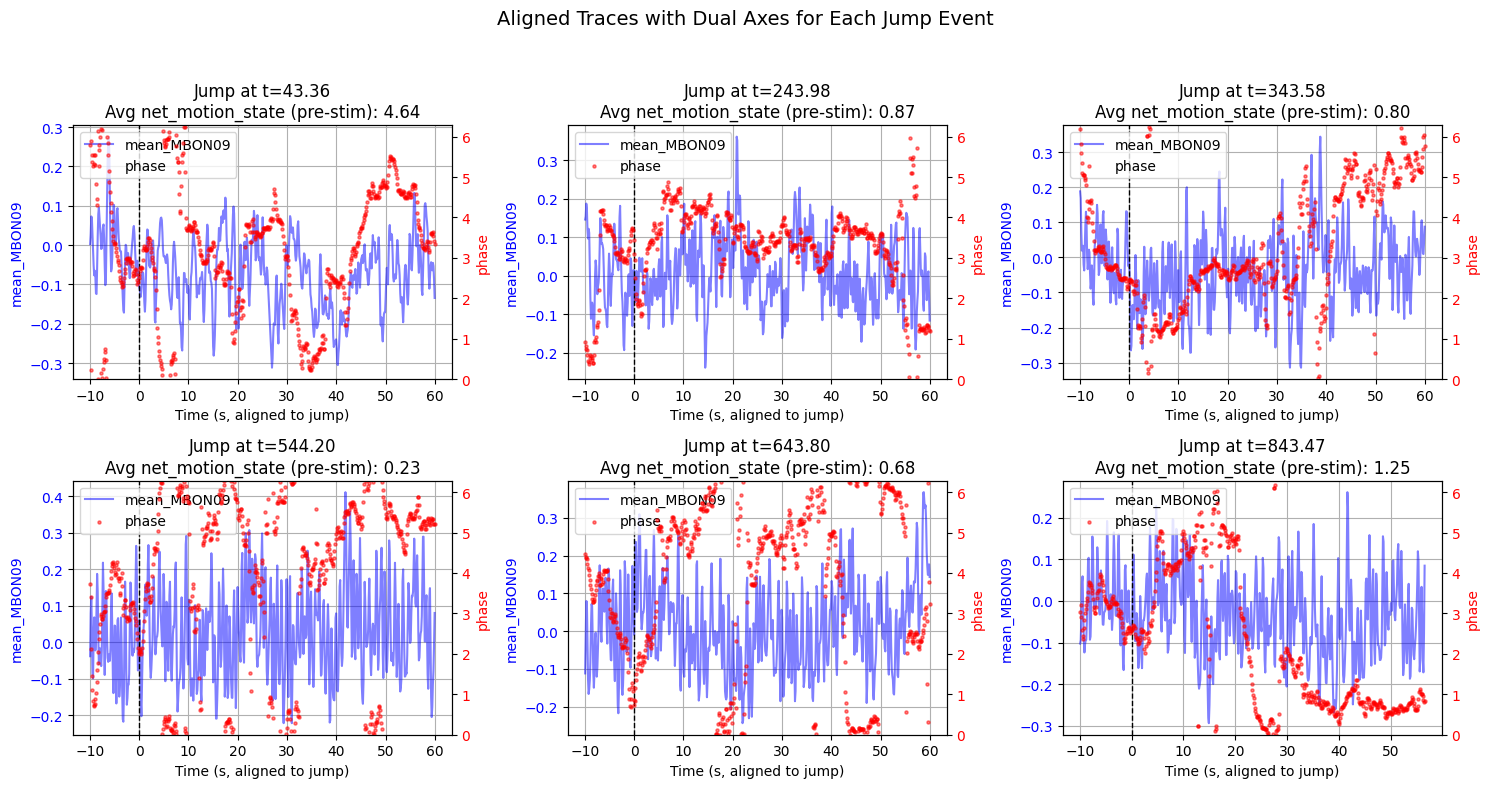

In [362]:
plot_aligned_traces_twinx(
    merged_df, 'bar_sweep', ['mean_MBON09','phase'], 'time',align_to="on", window=(-10, 60), is_circular=[False,True], do_baselincorr=True
)

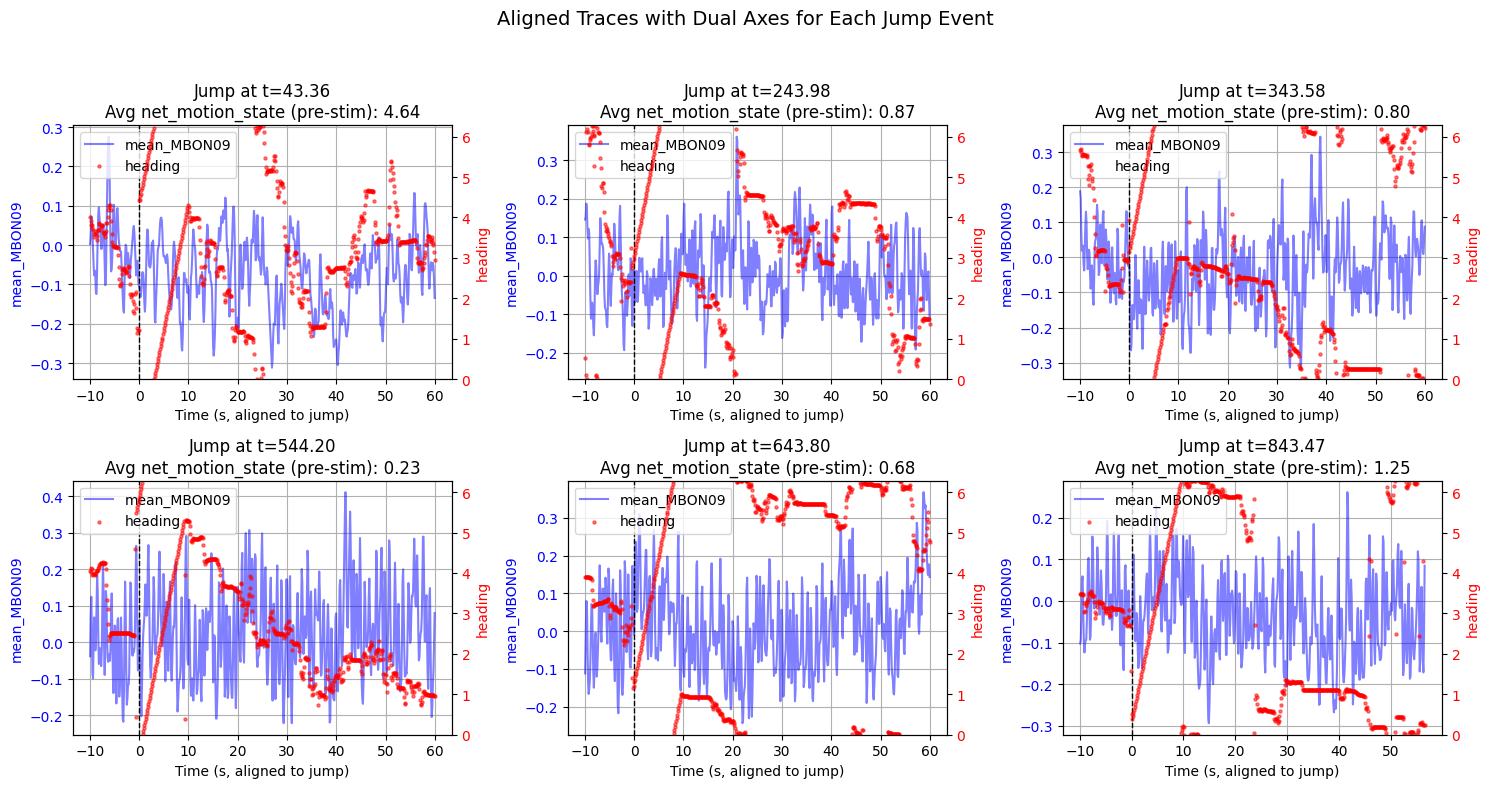

In [363]:
plot_aligned_traces_twinx(
    merged_df, 'bar_sweep', ['mean_MBON09','heading'], 'time',align_to="on", window=(-10, 60), is_circular=[False,True], do_baselincorr=True
)

C:\Users\wilson\AppData\Local\Temp\ipykernel_4876\4170727592.py:695: RuntimeWarning: Mean of empty slice
  mean_trace = np.nanmean(traces_stack, axis=0)
c:\Users\wilson\anaconda3\envs\2p_process\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


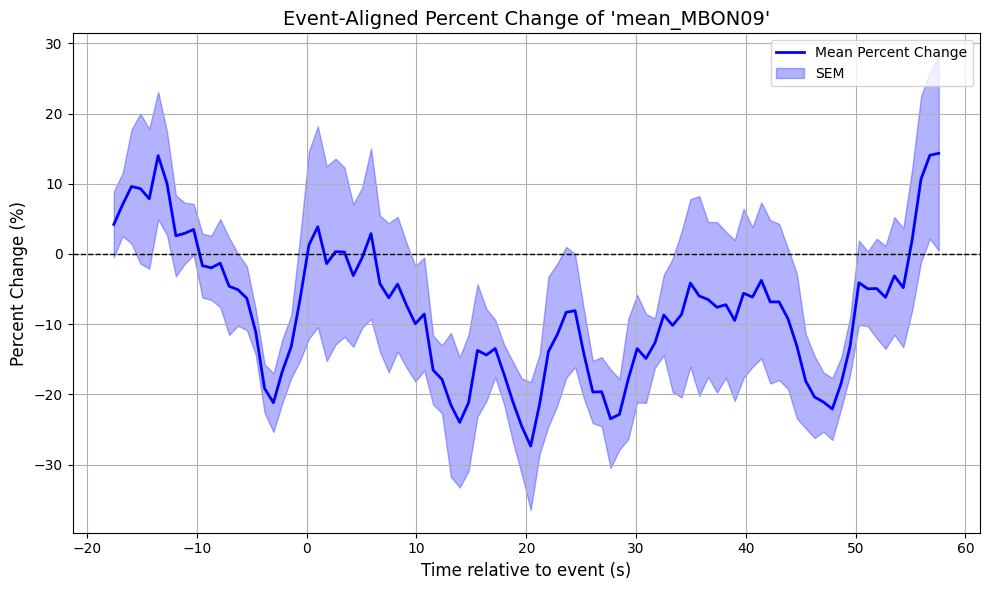

In [387]:
plot_event_percent_change_smoothed(merged_df, 'mean_MBON09', event_col='bar_sweep', time_col='time',
                              event_window=(-20, 60), baseline_window=(-20, 0),
                              circular=False, n_points=100, title=None,
                              plot_individual=False, smooth_window=5)

### Load new and examine bar jump

In [13]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/standby/"
folder_name = "20250302-3_MBON09hDeltaB_visualopenloop"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 1
bar_jump = False
bar_sweep = False
is_mat73, roi_df, dff_raw = imaging_behavior_functions_cleaned.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = imaging_behavior_functions_cleaned.get_roi_seq_2(roi_df,trial_num)
dff_all_rois, dff_time = imaging_behavior_functions_cleaned.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions_cleaned.make_df_neural(
    dff_all_rois,
    dff_time,
    roi_names,
    hdeltab_index,
    epg_index,
    fr1_index,
    fb4r_index,
    hdeltab_sequence,
    epg_sequence,
    fr1_sequence,
    fb4r_seq
)
neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
roi_kw = 'hDeltaB'
roi_kw2 = 'CRE'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions_cleaned.extract_roi_mtx(neural_df, roi_kw, roi_kw2)
    neural_df,param_df = imaging_behavior_functions_cleaned.fit_sinusoid(neural_df, roi_mtx)
    neural_df = imaging_behavior_functions_cleaned.calculate_pva_hdeltab(roi_mtx.T, neural_df)
    
behav_df, neural_df_new = imaging_behavior_functions_cleaned.load_matfile_to_df(example_path_data, folder_name, trial_num,is_odor_trial=True)
behav_df = imaging_behavior_functions_cleaned.rename_dataframe(behav_df)
if bar_jump:
    behav_df = imaging_behavior_functions_cleaned.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions_cleaned.detect_local_peaks(behav_df, init_t=0, prominence=0.1, min_time_gap=100)
behav_df = imaging_behavior_functions_cleaned.make_df_behavior_new(behav_df)
behav_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(behav_df)
merged_df = imaging_behavior_functions_cleaned.merge_dataframes(neural_df, behav_df,method='direct')
if bar_sweep:
    merged_df=imaging_behavior_functions_cleaned.detect_bar_sweep(merged_df, theta=0, t2=60, noise_threshold=0.05, duration_tol=0.5)
# bar jump use nearest method, bar sweep use interp method

Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
Loaded using mat73.


In [14]:
# Plot the data
plt.figure(figsize=(12, 5))
plt.plot(behav_df["time"], behav_df["absolute_circular_diff"], label="Absolute Circular Diff", alpha=0.7)
plt.scatter(behav_df[behav_df["jump_detected"] == 1]["time"], 
            behav_df[behav_df["jump_detected"] == 1]["absolute_circular_diff"], 
            color='red', label="Detected Peaks", zorder=3)
plt.xlabel("Time")
plt.ylabel("Absolute Circular Diff")
plt.legend()
plt.title("Detected Peaks in Time Series")
plt.show()




KeyError: 'absolute_circular_diff'

<Figure size 1200x500 with 0 Axes>

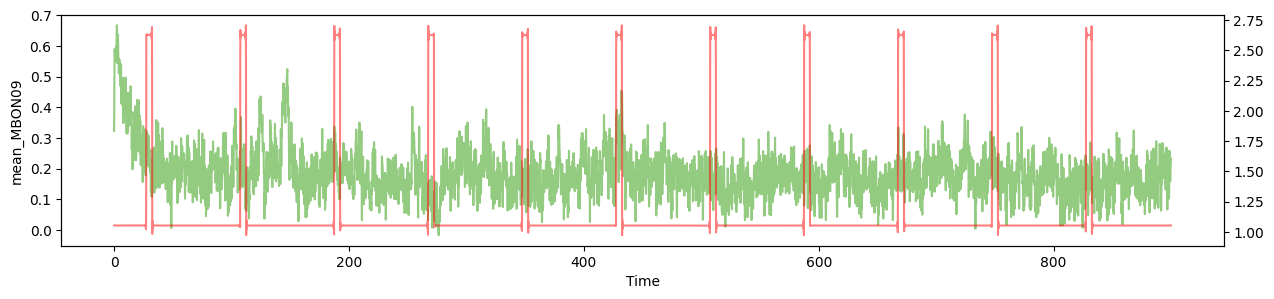

In [17]:
key = 'mean_MBON09'
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2],color=(41/256,154/256,4/256),alpha=0.5)
ax2 = ax.twinx()
ax2.plot(behav_df.time[idx1:idx2], behav_df.heading[idx1:idx2], color='red',alpha=0.5)
#ax2.scatter(neural_df.time[idx1:idx2], neural_df.phase[idx1:idx2], color='red',s=1,alpha=0.5)
#ax2.scatter(behav_df[behav_df["jump_detected"] == 1]["time"], 
            #behav_df[behav_df["jump_detected"] == 1]["absolute_circular_diff"], 
            #color='blue', label="Detected Peaks", zorder=3)
ax.set_xlabel('Time')
ax.set_ylabel(key)
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

KeyError: 'jump_detected'

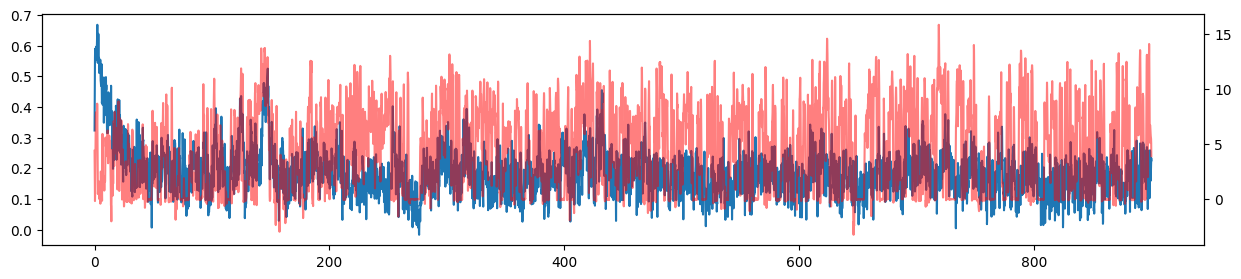

In [10]:
key = 'mean_MBON09'
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2])
ax2 = ax.twinx()
ax2.plot(behav_df.time[idx1:idx2], behav_df.fwV[idx1:idx2], color='red',alpha=0.5)
#ax2.scatter(neural_df.time[idx1:idx2], neural_df.phase[idx1:idx2], color='red',s=1,alpha=0.5)
ax2.scatter(behav_df[behav_df["jump_detected"] == 1]["time"], 
            behav_df[behav_df["jump_detected"] == 1]["absolute_circular_diff"], 
            color='blue', label="Detected Peaks", zorder=3)
ax.set_xlabel('Time')
ax.set_ylabel(key)
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

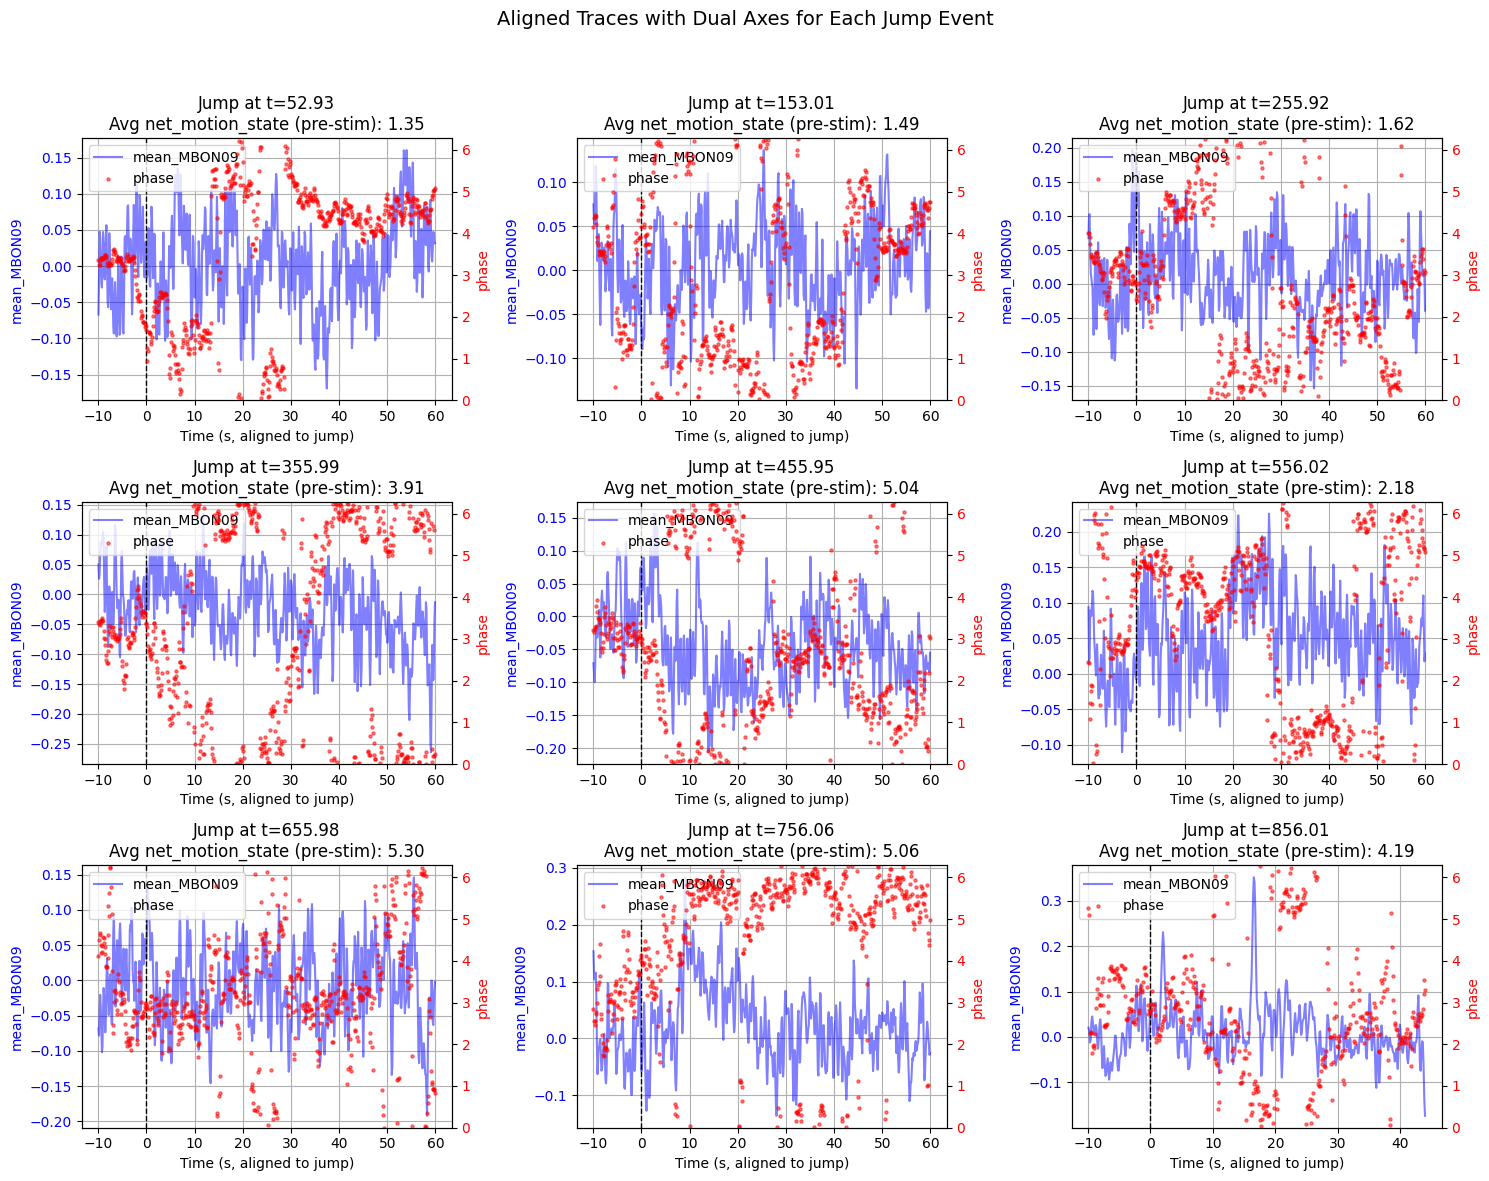

In [190]:
plot_aligned_traces_twinx(
    merged_df, 'jump_detected', ['mean_MBON09','phase'], 'time',align_to="on", window=(-10, 60), is_circular=[False,True], do_baselincorr=True
)

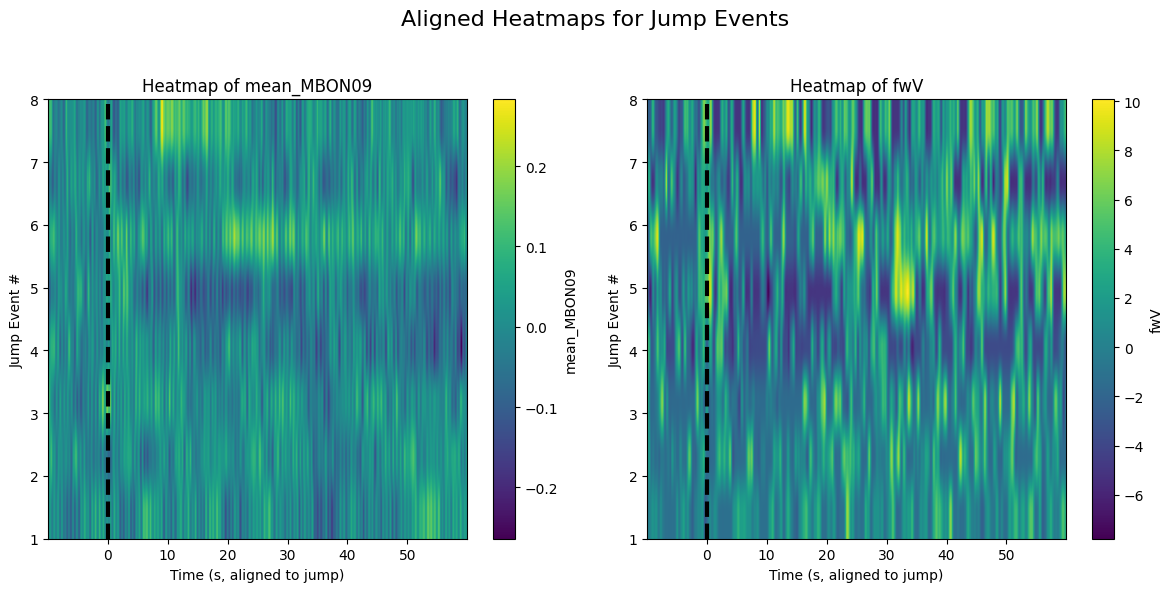

In [191]:
plot_heatmap_aligned_traces(
   merged_df, 'jump_detected', ['mean_MBON09','fwV'], 'time',align_to="on", window=(-10, 60), is_circular=[False,False], do_baselincorr=True
)

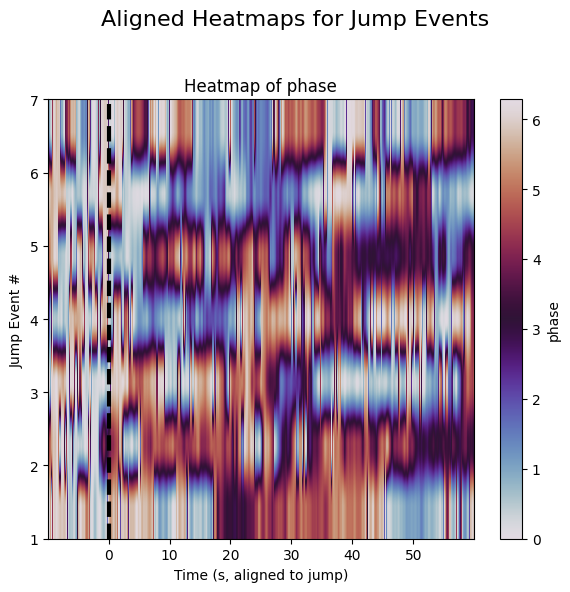

In [44]:
plot_heatmap_aligned_traces(
   merged_df, 'jump_detected', ['phase'], 'time',align_to="on", window=(-10, 60), is_circular=[True], do_baselincorr=True
)

C:\Users\wilson\AppData\Local\Temp\ipykernel_20552\3240256221.py:951: RuntimeWarning: Mean of empty slice
  mean_trace = np.nanmean(traces_stack, axis=0)
c:\Users\wilson\anaconda3\envs\2p_process\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


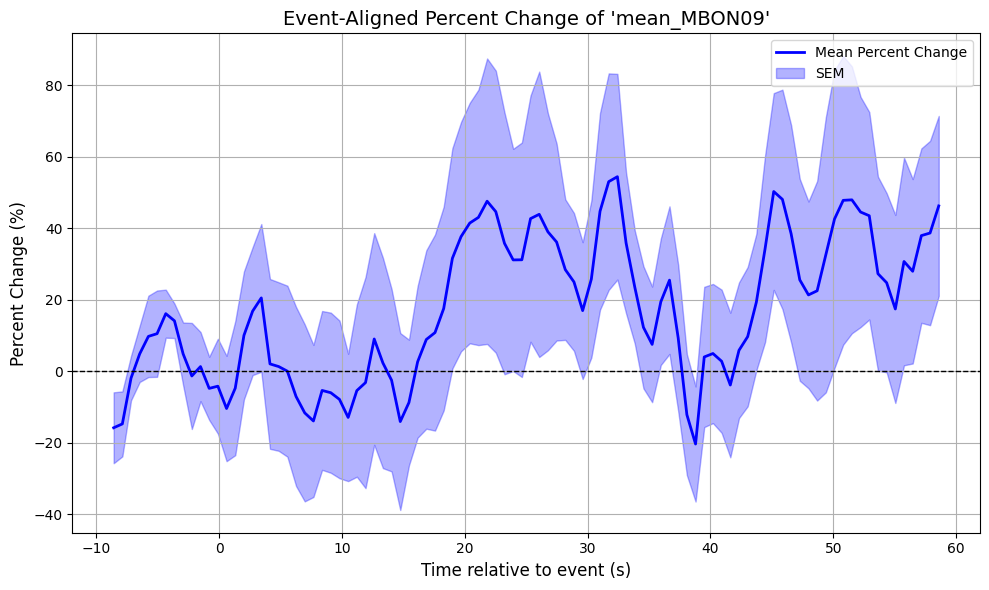

In [49]:
plot_event_percent_absolute(merged_df, 'mean_MBON09', event_col='jump_detected', time_col='time',
                              event_window=(-10, 60), baseline_window=(-10, 0),
                              circular=False, n_points=100, title=None,
                              plot_individual=False, smooth_window=3)

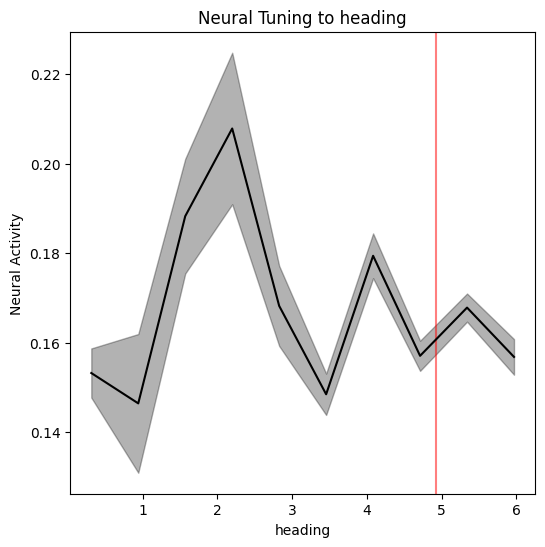

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#imaging_behavior_functions_plotting.plot_scatter(merged_df, 'phase', 'mean_MBON21', ax=ax, return_fig=False)
circular_mode = imaging_behavior_functions_plotting.circular_mode(merged_df[idx1:idx2]['heading'], method='histogram')
ax.axvline(circular_mode,color='red',alpha=0.5)
imaging_behavior_functions_plotting.tuning_curve_1d(merged_df.iloc[idx1:idx2], 'heading', key, num_bins=10, ax=ax, return_fig=False)

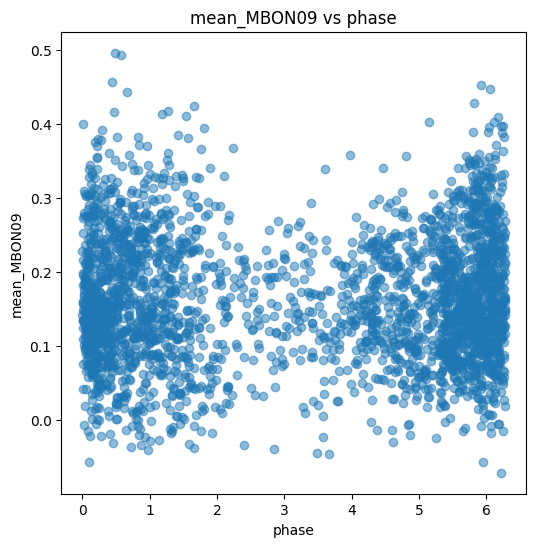

In [73]:
key = 'mean_MBON09'
fig, ax = plt.subplots(figsize=(6, 6))
imaging_behavior_functions_plotting.plot_scatter(merged_df[idx1:idx2], 'phase', key, ax=ax, return_fig=False)

### Load new and examine dark


In [152]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/new acquisition/"
folder_name = "20250219-5_MBON21hDeltaB_jump_nobar_fly2"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 1
bar_jump = False
bar_sweep = False
is_mat73, roi_df, dff_raw = imaging_behavior_functions_cleaned.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = imaging_behavior_functions_cleaned.get_roi_seq_2(roi_df,trial_num)
dff_all_rois, dff_time = imaging_behavior_functions_cleaned.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions_cleaned.make_df_neural(
    dff_all_rois,
    dff_time,
    roi_names,
    hdeltab_index,
    epg_index,
    fr1_index,
    fb4r_index,
    hdeltab_sequence,
    epg_sequence,
    fr1_sequence,
    fb4r_seq
)
neural_df = imaging_behavior_functions_cleaned.compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
roi_kw = 'hDeltaB'
roi_kw2 = 'CRE'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions_cleaned.extract_roi_mtx(neural_df, roi_kw, roi_kw2)
    neural_df = imaging_behavior_functions_cleaned.calculate_pva_hdeltab(roi_mtx.T, neural_df)
    
behav_df, neural_df_new = imaging_behavior_functions_cleaned.load_matfile_to_df(example_path_data, folder_name, trial_num,is_odor_trial=True)
behav_df = imaging_behavior_functions_cleaned.rename_dataframe(behav_df)
if bar_jump:
    behav_df = imaging_behavior_functions_cleaned.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions_cleaned.detect_local_peaks(behav_df, init_t=0, prominence=0.1, min_time_gap=60)
behav_df = imaging_behavior_functions_cleaned.make_df_behavior_new(behav_df)
behav_df = imaging_behavior_functions_cleaned.calculate_theta_g_rho(behav_df)
merged_df = imaging_behavior_functions_cleaned.merge_dataframes(neural_df, behav_df)
if bar_sweep:
    merged_df=imaging_behavior_functions_cleaned.detect_bar_sweep(merged_df, theta=0, t2=60, noise_threshold=0.05, duration_tol=0.5)
# bar jump use nearest method, bar sweep use interp method

Neither ['MBON09R', 'MBON09_R'] nor ['MBON09L', 'MBON09_L'] found in DataFrame.
Loaded using mat73.


<Axes: >

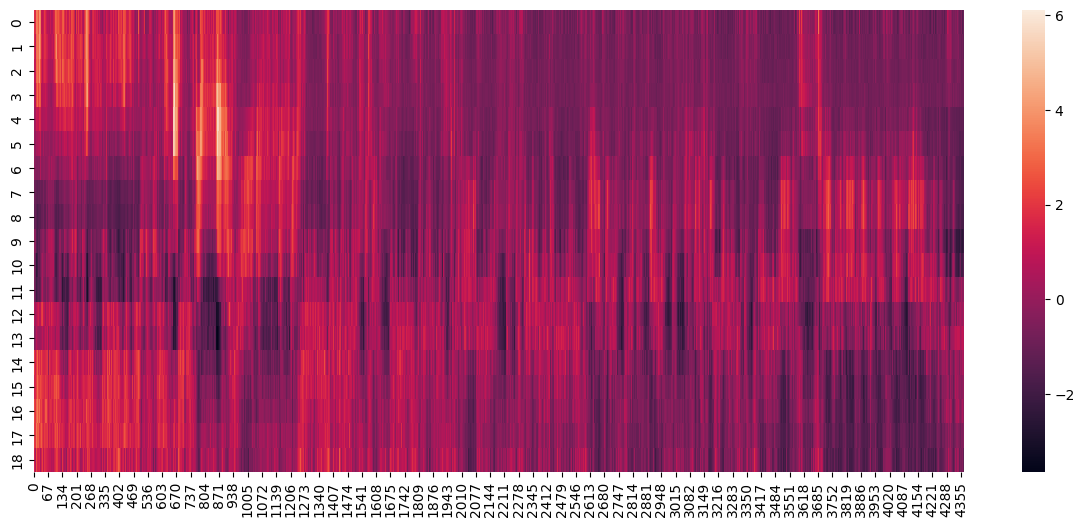

In [153]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.heatmap(roi_mtx.T, ax=ax)


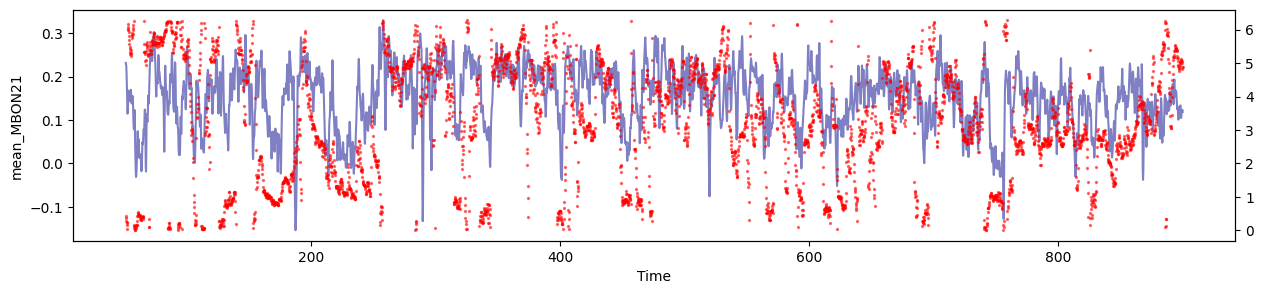

In [154]:
key = 'mean_MBON21'
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2],color = 'darkblue',alpha =0.5)
ax2 = ax.twinx()
ax2.scatter(neural_df.time[idx1:idx2], neural_df.phase[idx1:idx2], color='red',s = 2, alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)


plt.show()

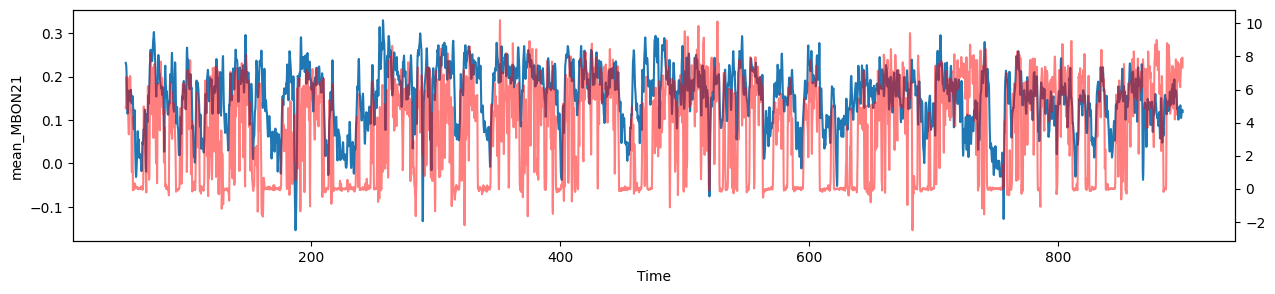

In [155]:

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 250
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2])
ax2 = ax.twinx()
ax2.plot(merged_df.time[idx1:idx2], merged_df.fwV[idx1:idx2], color='red',alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

AttributeError: 'DataFrame' object has no attribute 'baseline'

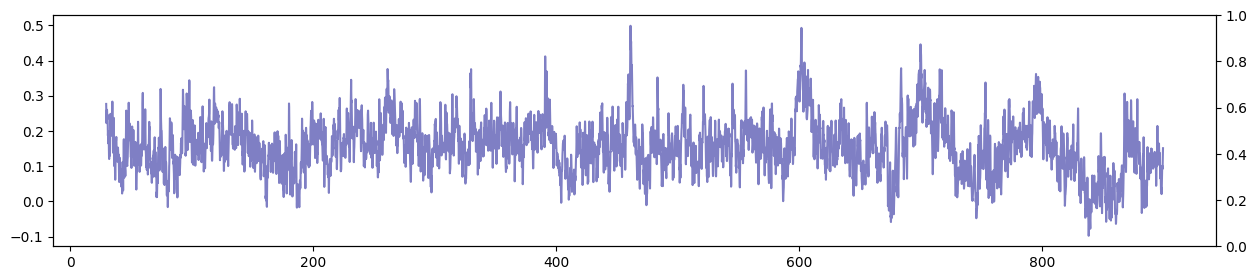

In [136]:
key = 'mean_MBON09'
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2],color = 'darkblue',alpha =0.5)
ax2 = ax.twinx()
ax2.plot(neural_df.time[idx1:idx2], neural_df.baseline[idx1:idx2], color='red', alpha=0.5)

ax.set_xlabel('Time')
ax.set_ylabel(key)


plt.show()